## Template Matching Proof-of-Concept
#### Author: Christian Grech (MXL, DESY)

### Introduction

<p> The following image shows the SASE 2 beamline at the European XFEL, set up for Hard Xray Self Seeding (HXRSS). In an undulator, alternating magnetic field causes the emission of Xray radiation from electrons. Crystals are then used to filter certain wavelengths/energies. Two crystals can be used but mostly at the EuXFEL, crystal 2 is used. The label for crystal 1 is XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2 and the label for crystal 2 is XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2. The crystals filter out certain photon energies and transmit only particular reflections. We give these reflections an identifier [h,k,l] where h and k and l are integers and this number specifies the direction and plane that the reflection is hitting the crystal. For example for this experiment we frequently use reflections [0,0,4] and [2,2,0].

![Undulator](images/und3.png)

<p> We have available a precise model which can predict the reflections according to how the crystal is positioned. The parameters hmax, kmax, lmax, dthp, dthy, dthr, alpha are normally unchanged. The roll angle depends on the roll of the crystal and the last three parameters are min_pitch, max_pitch and the number of points. Try experimenting with the model below. </p>


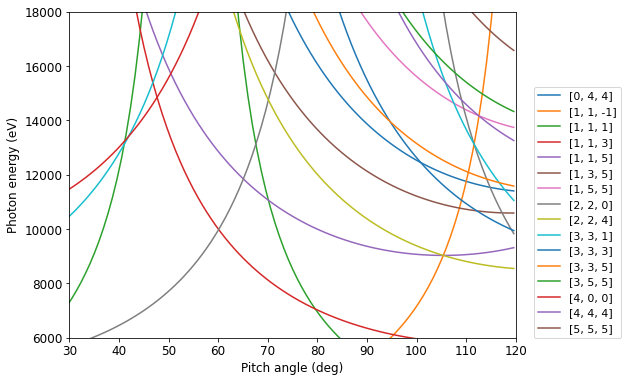

In [15]:
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 
import matplotlib.pyplot as plt

# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 8
kmax = 8
lmax = 8
dthp = -0.392
dthy = 1.17
dthr = -0.1675
alpha = 0.00238
roll_angle = 1.58

phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, 30, 120, 100)


plt.figure(figsize=(8,6),facecolor='white')

#plt.plot(x, y)
gidlegend = ['[0, 4, 4]', '[1, 1, 1]', '[1, 1, -1]', '[1, 1, 3]', '[1, 1, 5]', '[1, 3, 5]', '[1, 5, 5]', '[2, 2, 0]', '[2, 2, 4]', '[3, 3, 1]', '[3, 3, 3]', '[3, 3, 5]', '[3, 5, 5]', '[4, 0, 0]', '[4, 4, 4]', '[5, 5, 5]']

for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
    if gid in gidlegend:
        plt.plot(pangle, phen, label=gid) # I am only plotting a few reflections here but there are many more

plt.xlabel("Pitch angle (deg)")
plt.ylabel("Photon energy (eV)")
plt.rcParams.update({'font.size': 11})
plt.ylim(6000, 18000) # This is the range of energies we are interested in
plt.xlim(30, 120)
plt.legend(loc=(1.04,0))
#plt.title("Crystal Reflection Model")
plt.show()

### Spectrometer images

<p>A spectrometer is an instrument used to measure and record the emitted beam's spectral information. Thanks to a spectrometer at the end of the output undulator, we are able to measure the energy at different crystal pitch angles. This results in images as shown in figure 1 below, which are saved as npz files. The lines are the reflections similar to those shown in the model above. The issue with these image is that the y-axis (photon energy) is not always correct, as a random vertical offset is present everytime we use the instrument. We would like to compare these image with the model as shown in the second image below and find this energy difference.

<ipython-input-23-feaf1eb3c1ec>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(doocs_scale, phen_scale, orig_image, cmap='viridis', shading='auto')


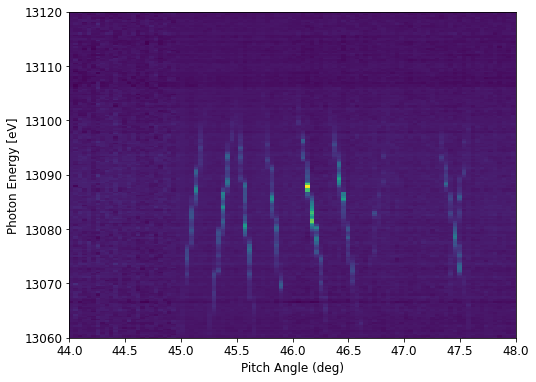

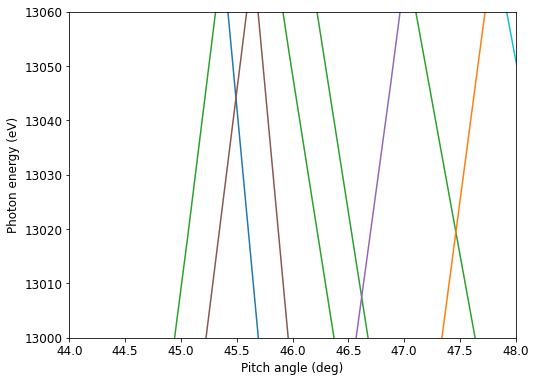

In [23]:
import numpy as np

# Load the spectrometer image
filepath = r'sampledata.nosync/20210925-22_04_34_cor2d.npz' 
tt = np.load(filepath)
corr2d = tt['corr2d']
orig_image = tt['corr2d'].T
spec_hist = tt['spec_hist']
doocs_scale = tt['doocs_scale']
phen_scale = tt['phen_scale']
doocs_label = tt['doocs_channel']


# Plot the spectrometer image
plt.figure(figsize=(8,6),facecolor='white')
plt.rcParams.update({'font.size': 12})

plt.pcolormesh(doocs_scale, phen_scale, orig_image, cmap='viridis', shading='auto')
#plt.title(doocs_label)

plt.xlabel('Pitch Angle (deg)')
plt.ylabel(r'Photon Energy [eV]')
plt.ylim(13060, 13120) # This is the range of energies we are interested in
plt.xlim(44, 48)
#plt.ylim(13090, 13150) # This is the range of energies we are interested in
plt.show()

# Plot the model
plt.figure(figsize=(8,6),facecolor='white')
for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
    plt.plot(pangle, phen, label=gid) # I am only plotting a few reflections here but there are many more

plt.xlabel("Pitch angle (deg)")
plt.ylabel("Photon energy (eV)")
plt.ylim(13000, 13060)
plt.xlim(44, 48)
#plt.title("Crystal Reflection Model")
plt.show()

### Hough Transform

<p> The roll angle is obtained from the corresponding status text file or from the pickle file database where this file is not available. The image is created from the model with the function Bragg_plotter_limit which takes the following inputs: hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, minimum pitch value, max pitch value, number of points. The outputs are the photon energy values, pitch angle values, reflection id, linestyle and color.</p>

In [5]:
from functions.HXRSS_tool_plotter_limit import Bragg_plotter_limit  # Crystal model 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import re
import time
from datetime import datetime, timezone
import pytz
import matplotlib.colors as colors

from skimage import data
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import match_template
from skimage.filters import threshold_yen

### Input settings

In [127]:
directory = r'sampledata.nosync/'           # This is the folder with the images and corresponding status files
readfromdb = "database/op_20220607.pkl"     # This is a dataframe with past calibration values and roll angle information for images with no status file
df_db = pd.read_pickle(readfromdb)

m=0
# Model parameters, these should remain unchanged unless the photon energy is above 15 keV where hmax = 6, kmax = 6, lmax = 7.
hmax = 6
kmax = 6
lmax = 7
dthp = -0.392
dthy = 1.192
dthr = -0.1675
alpha = 0.00238

### Functions

In [128]:
# this function is used to get the roll angle from the pickle database based on the nearest available date
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

### Iterate through images and perform matching


Monochromator 2 image found; from database: roll angle=1.0869 deg 

20200927-21_07_47_cor2d.npz
Original measured point 9009.32 eV
Matched model point 9128.61 eV
Template Matching Calibration 119.29 eV
Estimated Calibration (by visual inspection) 120.0 eV 



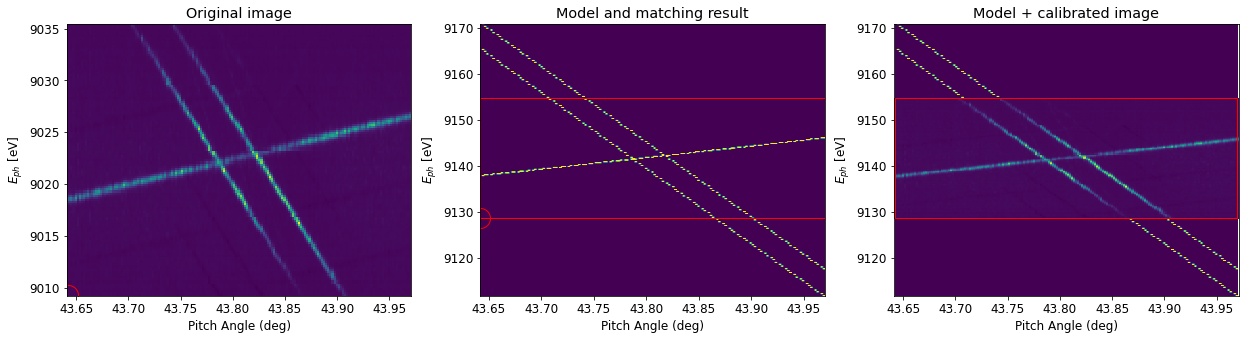

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20201004-10_31_43_cor2d.npz
Original measured point 9002.1 eV
Matched model point 9084.2 eV
Template Matching Calibration 82.1 eV
Estimated Calibration (by visual inspection) 83.0 eV 



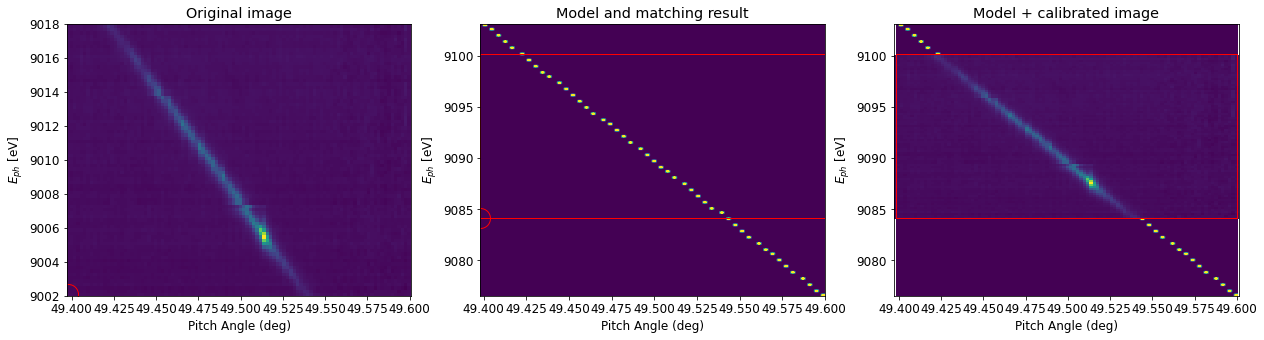

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20201004-13_09_14_cor2d.npz
Original measured point 9005.1 eV
Matched model point 9088.24 eV
Template Matching Calibration 83.14 eV
Estimated Calibration (by visual inspection) 83.0 eV 



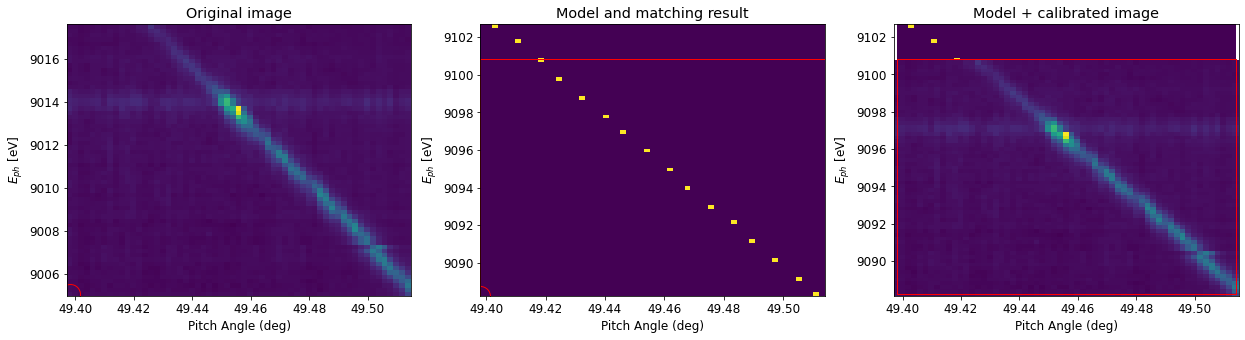

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20201022-06_22_52_cor2d.npz
Original measured point 8962.27 eV
Matched model point 9143.81 eV
Template Matching Calibration 181.55 eV
Estimated Calibration (by visual inspection) 177.0 eV 



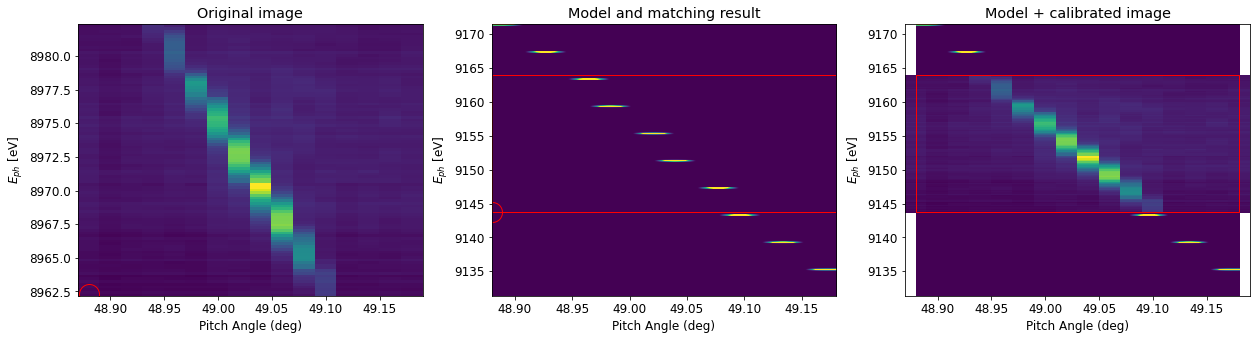

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201118-20_50_56_cor2d.npz
Original measured point 12905.47 eV
Matched model point 13088.34 eV
Template Matching Calibration 182.87 eV
Estimated Calibration (by visual inspection) 201.0 eV 



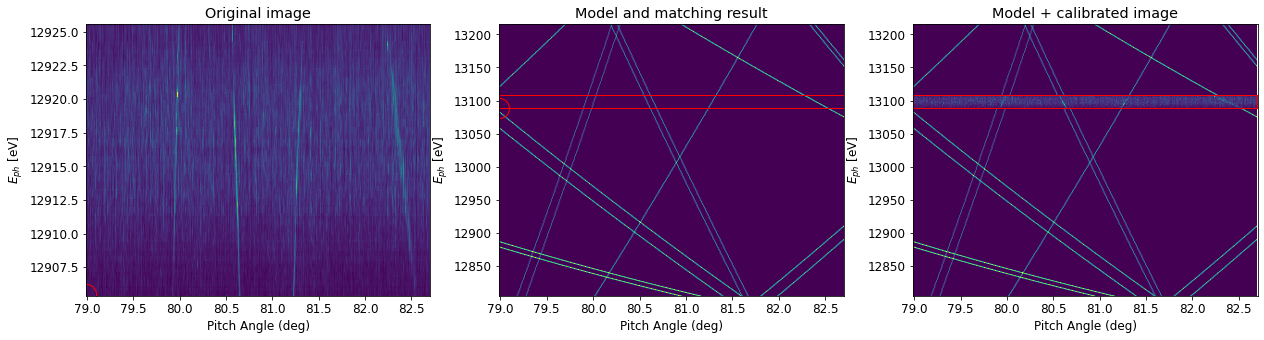

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201119-03_03_27_cor2d.npz
Original measured point 13083.07 eV
Matched model point 13086.44 eV
Template Matching Calibration 3.37 eV
Estimated Calibration (by visual inspection) 201.0 eV 



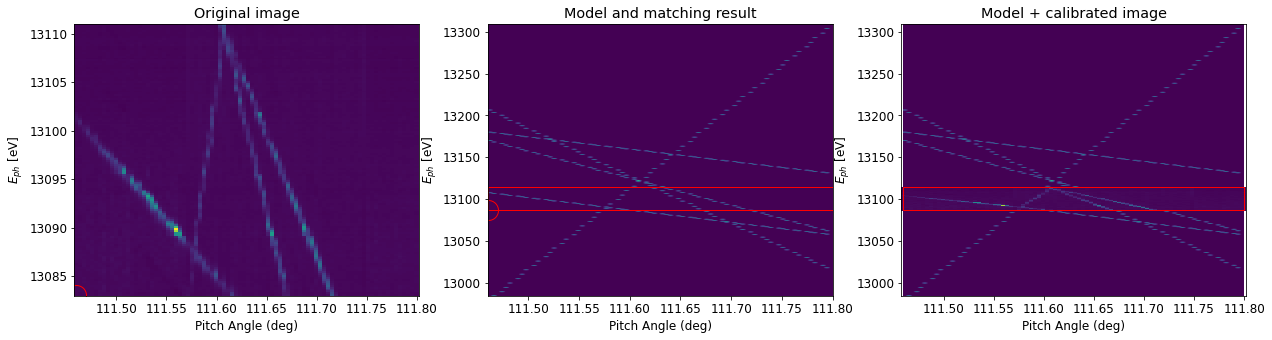

Monochromator 2 image found; from database: roll angle=1.438 deg 

20201119-03_20_19_cor2d.npz
Original measured point 13104.68 eV
Matched model point 13103.04 eV
Template Matching Calibration -1.64 eV
Estimated Calibration (by visual inspection) 201.0 eV 



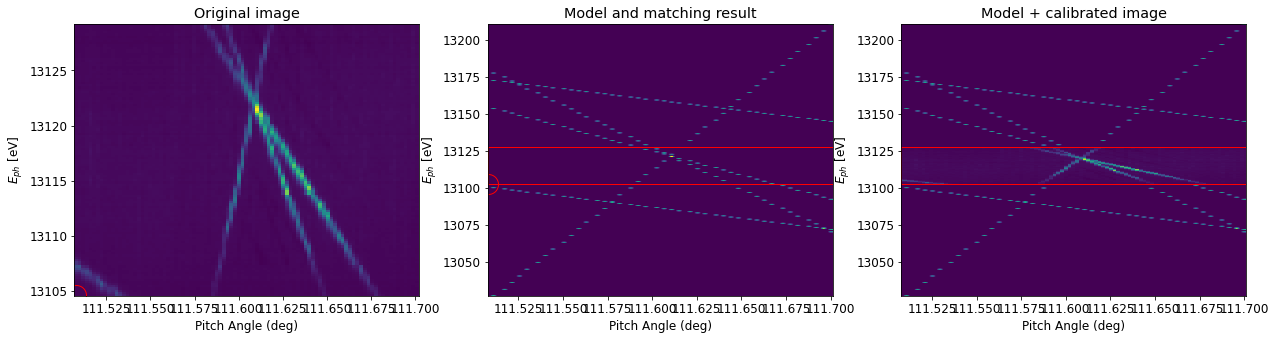

Monochromator 2 image found; from database: roll angle=1.45 deg 

20201119-21_41_05_cor2d.npz
Original measured point 13085.21 eV
Matched model point 13093.3 eV
Template Matching Calibration 8.09 eV
Estimated Calibration (by visual inspection) 201.0 eV 



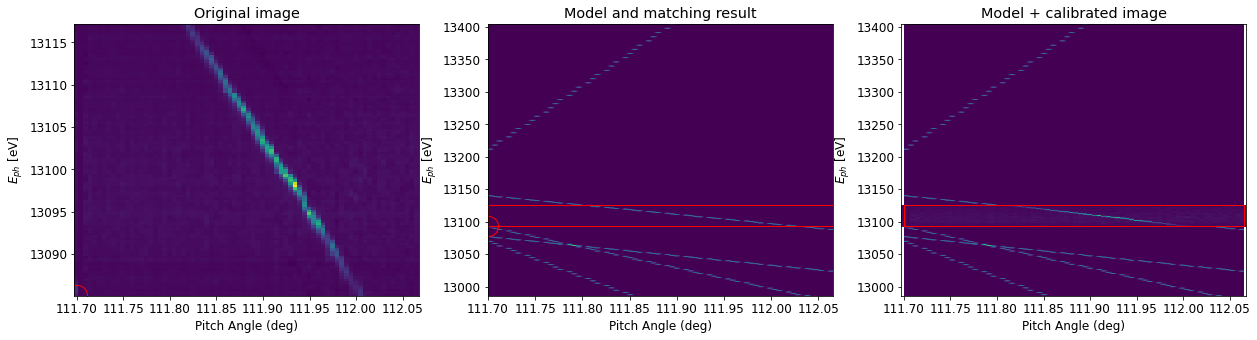

Monochromator 2 image found; from database: roll angle=1.45 deg 

20201120-03_24_28_cor2d.npz
Original measured point 13103.22 eV
Matched model point 13084.23 eV
Template Matching Calibration -18.99 eV
Estimated Calibration (by visual inspection) 201.0 eV 



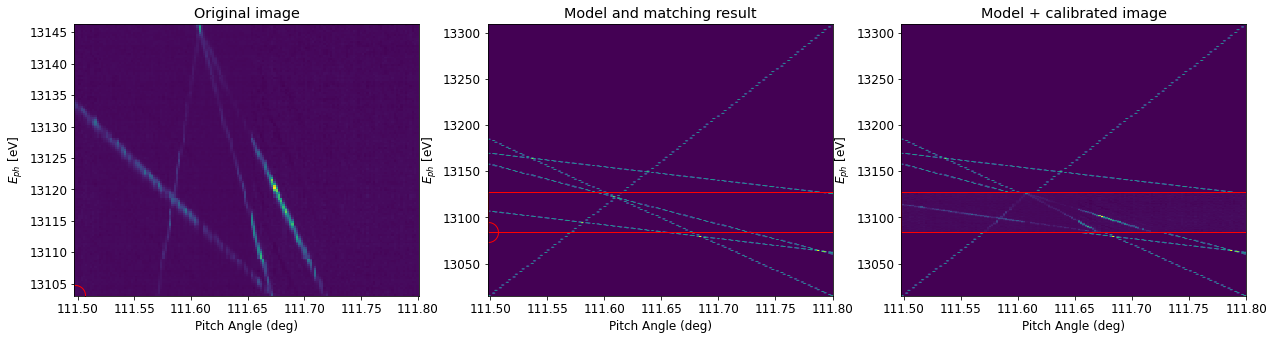

Monochromator 2 image found; from database: roll angle=1.07 deg 

20210304-19_01_28_cor2d.npz
Original measured point 7494.79 eV
Matched model point 7555.06 eV
Template Matching Calibration 60.26 eV
Estimated Calibration (by visual inspection) 63.0 eV 



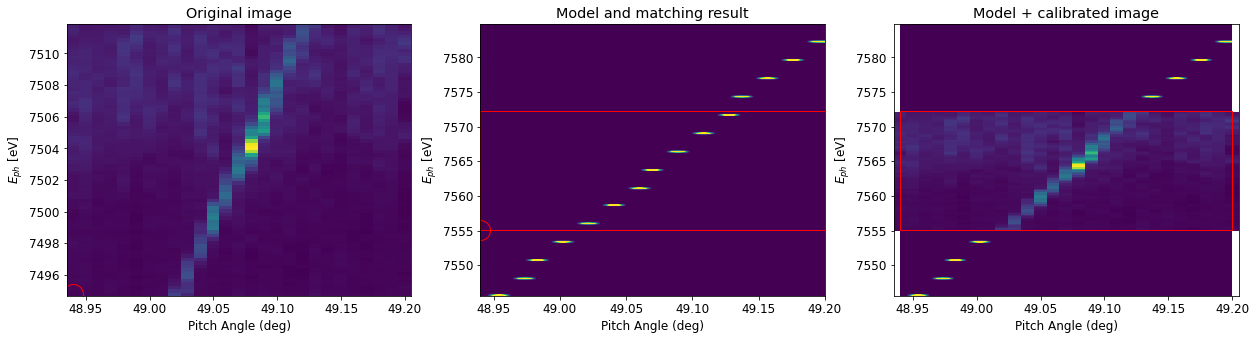

Monochromator 2 image found; from database: roll angle=1.13 deg 

20210305-21_13_39_cor2d.npz
Original measured point 7476.96 eV
Matched model point 7539.31 eV
Template Matching Calibration 62.35 eV
Estimated Calibration (by visual inspection) 60.0 eV 



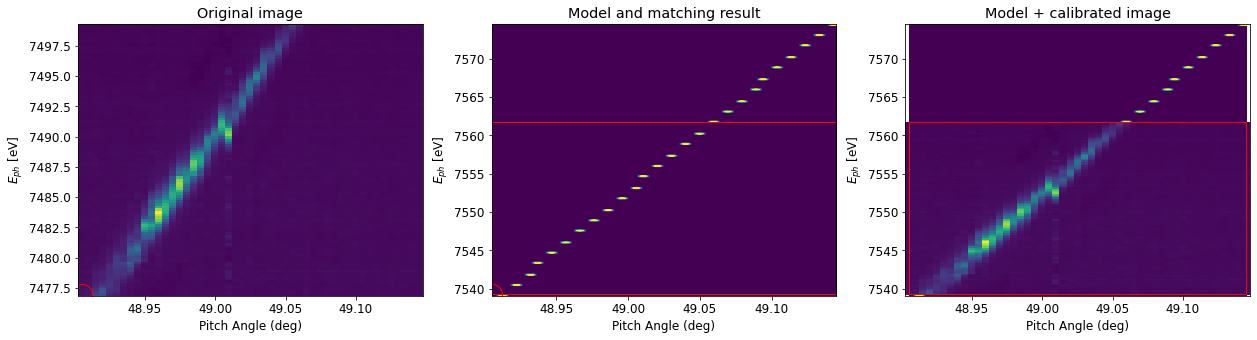

Monochromator 2 image found; from database: roll angle=1.13 deg 

20210305-22_30_14_cor2d.npz
Original measured point 7480.04 eV
Matched model point 7540.97 eV
Template Matching Calibration 60.93 eV
Estimated Calibration (by visual inspection) 60.0 eV 



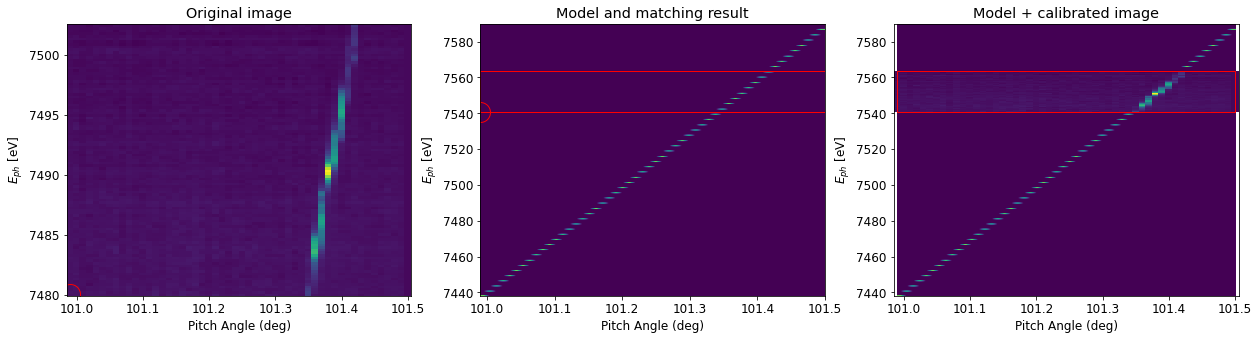

Monochromator 2 image found; from database: roll angle=1.13 deg 

20210307-22_06_17_cor2d.npz
Original measured point 7484.44 eV
Matched model point 7547.15 eV
Template Matching Calibration 62.7 eV
Estimated Calibration (by visual inspection) 55.0 eV 



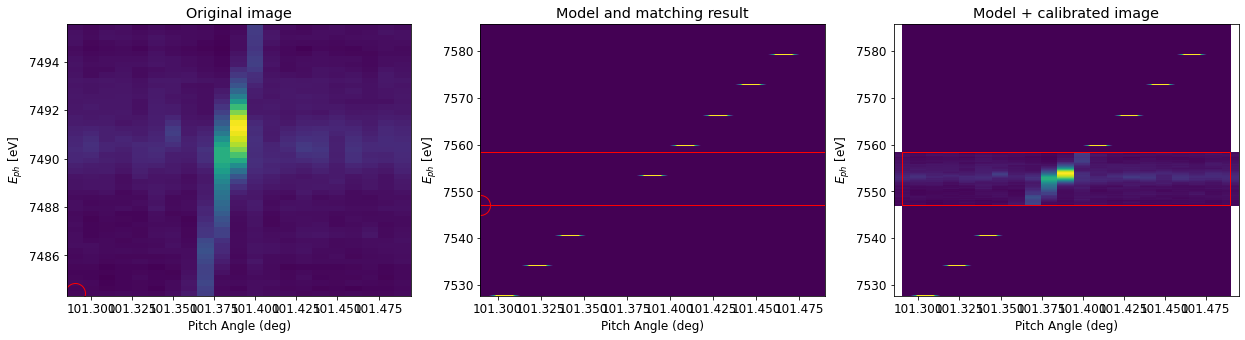

Monochromator 2 image found; from database: roll angle=1.2 deg 

20210312-19_26_23_cor2d.npz
Original measured point 8032.83 eV
Matched model point 8046.9 eV
Template Matching Calibration 14.07 eV
Estimated Calibration (by visual inspection) 15.0 eV 



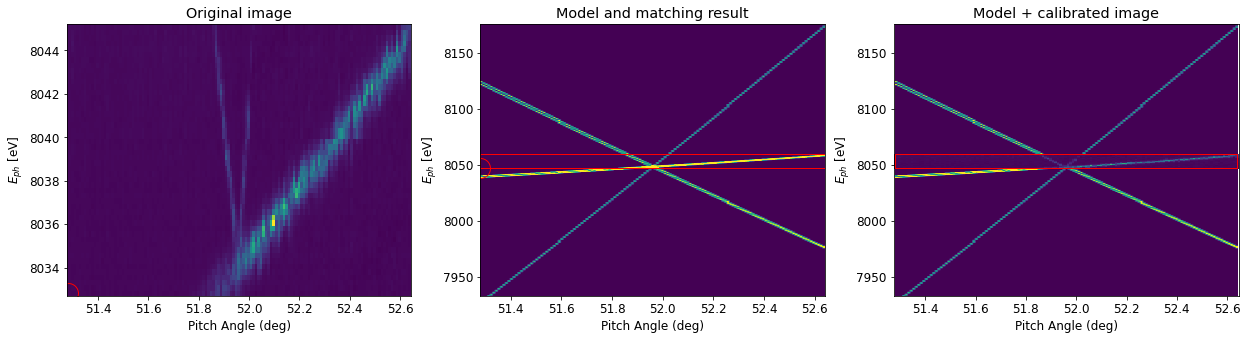

Monochromator 2 image found; from database: roll angle=1.31 deg 

20210317-14_32_17_cor2d.npz
Original measured point 9967.24 eV
Matched model point 10102.68 eV
Template Matching Calibration 135.44 eV
Estimated Calibration (by visual inspection) 142.0 eV 



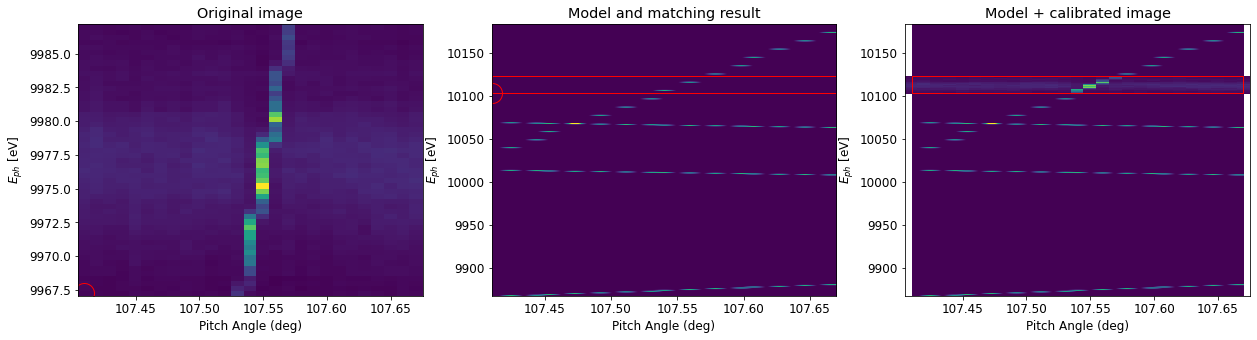

Monochromator 2 image found; from database: roll angle=1.31 deg 

20210317-15_27_19_cor2d.npz
Original measured point 9964.58 eV
Matched model point 10098.26 eV
Template Matching Calibration 133.68 eV
Estimated Calibration (by visual inspection) 142.0 eV 



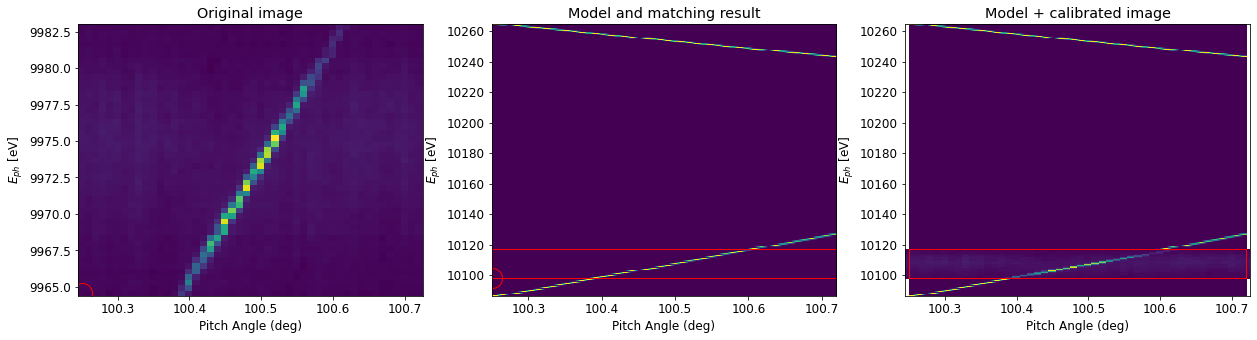

Monochromator 1 image found; from database: roll angle=1.43 deg 

20210325-18_00_55_cor2d.npz
Original measured point 7445.83 eV
Matched model point 7560.41 eV
Template Matching Calibration 114.58 eV
Estimated Calibration (by visual inspection) 52.0 eV 



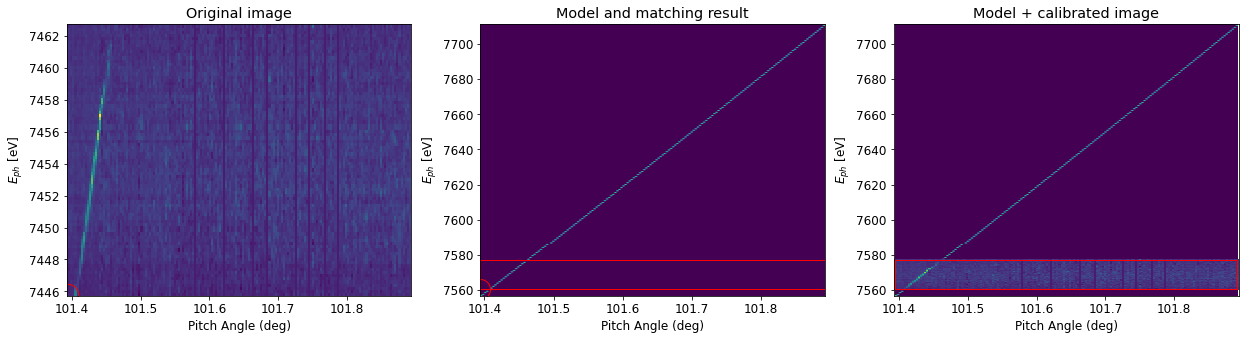

Monochromator 2 image found; from database: roll angle=1.43 deg 

20210325-23_27_02_cor2d.npz
Original measured point 7443.62 eV
Matched model point 7493.24 eV
Template Matching Calibration 49.62 eV
Estimated Calibration (by visual inspection) 52.0 eV 



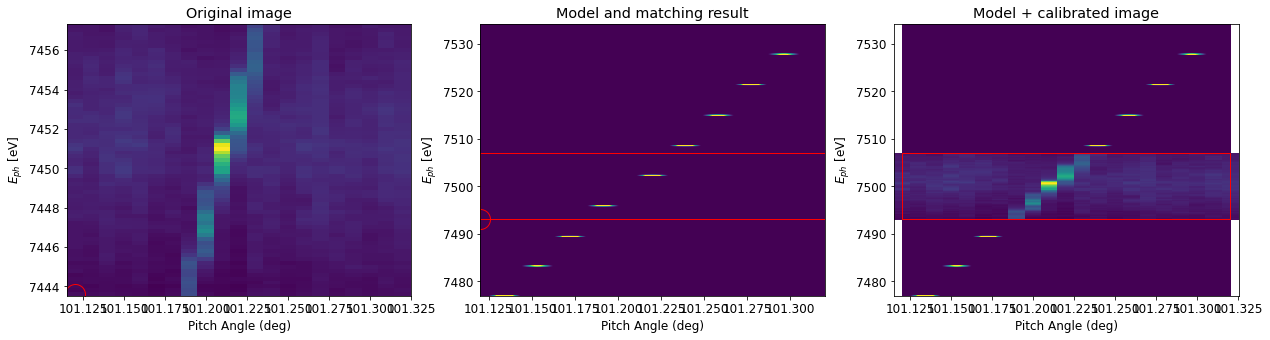

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20210510-16_10_14_cor2d.npz
Original measured point 7488.06 eV
Matched model point 7531.5 eV
Template Matching Calibration 43.44 eV
Estimated Calibration (by visual inspection) -50.0 eV 



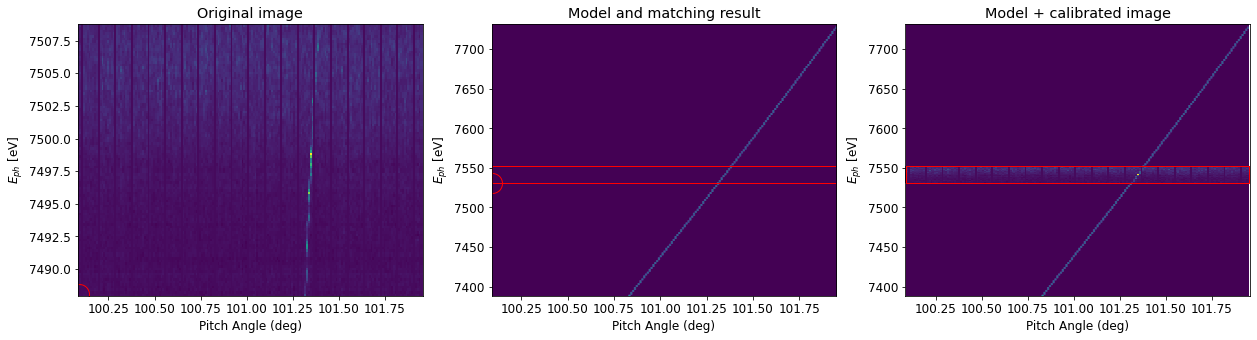

Monochromator 2 image found; from database: roll angle=1.4284 deg 

20210518-14_44_43_cor2d.npz
Original measured point 8942.76 eV
Matched model point 8971.6 eV
Template Matching Calibration 28.84 eV
Estimated Calibration (by visual inspection) -50.0 eV 



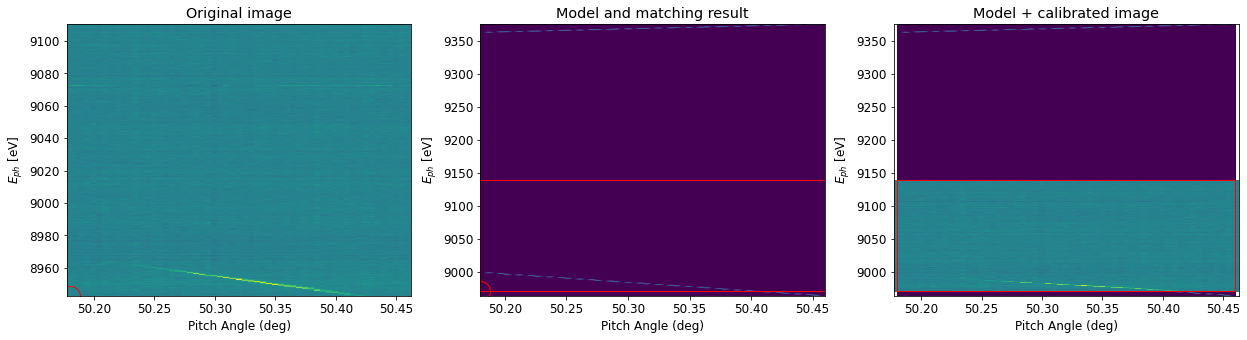

Monochromator 1 image found; from database: roll angle=1.4284 deg 

20210522-22_27_28_cor2d.npz
Original measured point 7497.24 eV
Matched model point 7514.71 eV
Template Matching Calibration 17.47 eV
Estimated Calibration (by visual inspection) 82.0 eV 



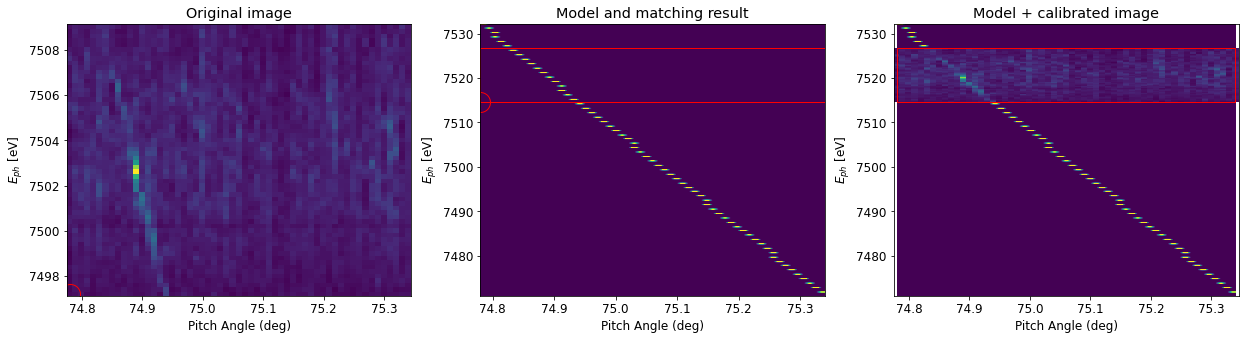

Monochromator 1 image found; from database: roll angle=1.4284 deg 

20210522-22_27_58_cor2d.npz
Original measured point 7497.24 eV
Matched model point 7514.94 eV
Template Matching Calibration 17.7 eV
Estimated Calibration (by visual inspection) 82.0 eV 



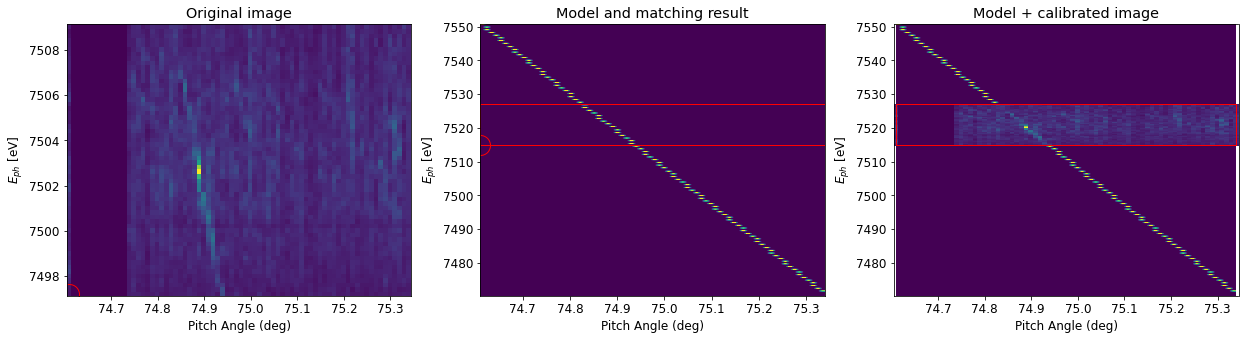

Monochromator 1 image found; from database: roll angle=1.4284 deg 

20210522-22_30_17_cor2d.npz
Original measured point 7498.04 eV
Matched model point 7514.98 eV
Template Matching Calibration 16.94 eV
Estimated Calibration (by visual inspection) 82.0 eV 



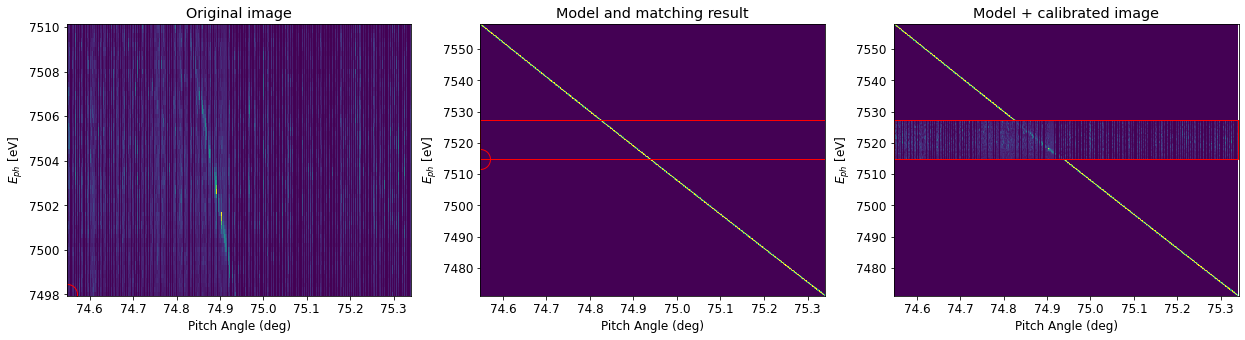

Monochromator 2 image found; from database: roll angle=1.1304 deg 

20210820-17_05_25_cor2d.npz
Original measured point 8986.33 eV
Matched model point 9127.92 eV
Template Matching Calibration 141.59 eV
Estimated Calibration (by visual inspection) -4.0 eV 



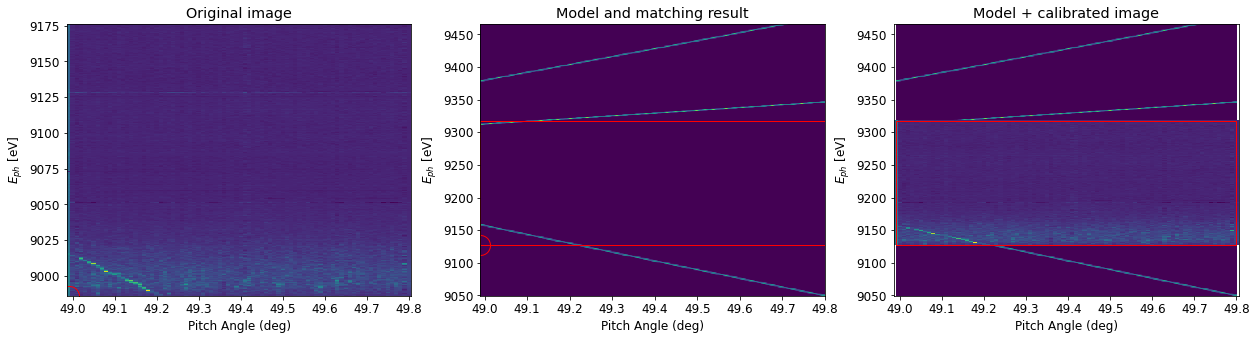

Monochromator 2 image found; from database: roll angle=1.1304 deg 

20210820-17_08_40_cor2d.npz
Original measured point 8990.5 eV
Matched model point 9132.79 eV
Template Matching Calibration 142.29 eV
Estimated Calibration (by visual inspection) -4.0 eV 



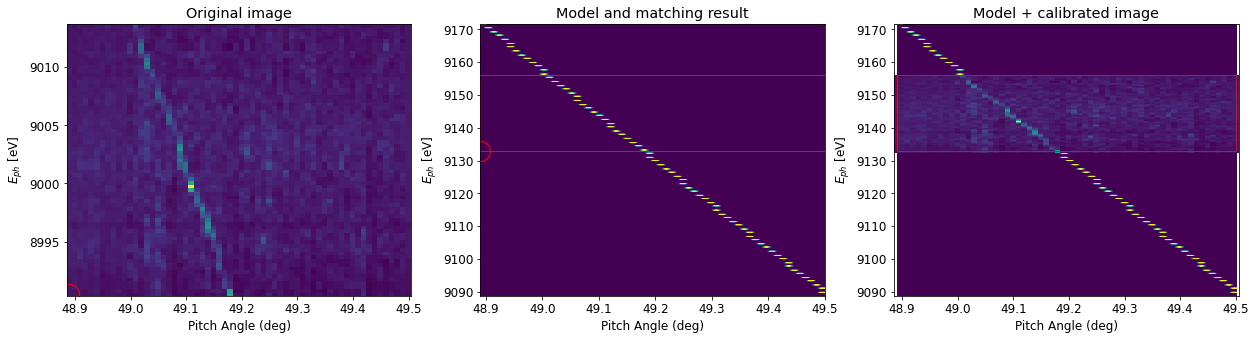

Monochromator 2 image found; from database: roll angle=1.1304 deg 

20210820-20_26_14_cor2d.npz
Original measured point 9047.22 eV
Matched model point 9037.81 eV
Template Matching Calibration -9.41 eV
Estimated Calibration (by visual inspection) -4.0 eV 



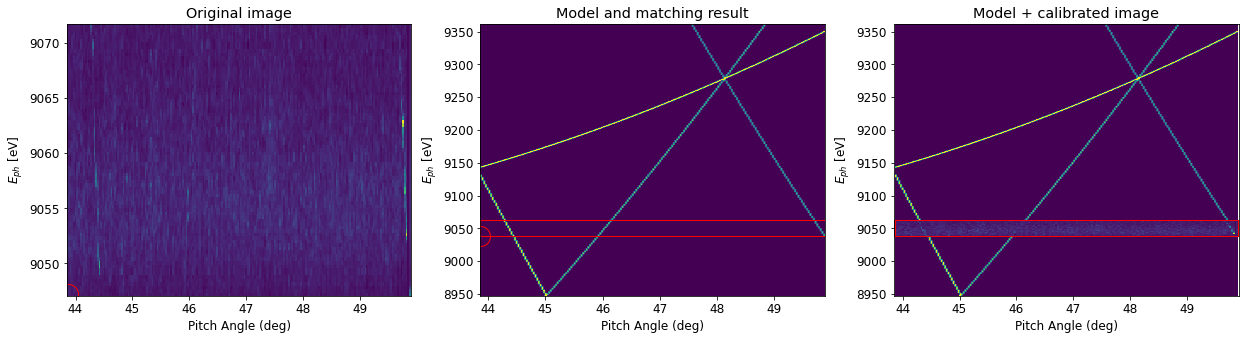

Monochromator 2 image found; from database: roll angle=1.1304 deg 

20210820-20_30_49_cor2d.npz
Original measured point 9047.54 eV
Matched model point 9038.23 eV
Template Matching Calibration -9.32 eV
Estimated Calibration (by visual inspection) -4.0 eV 



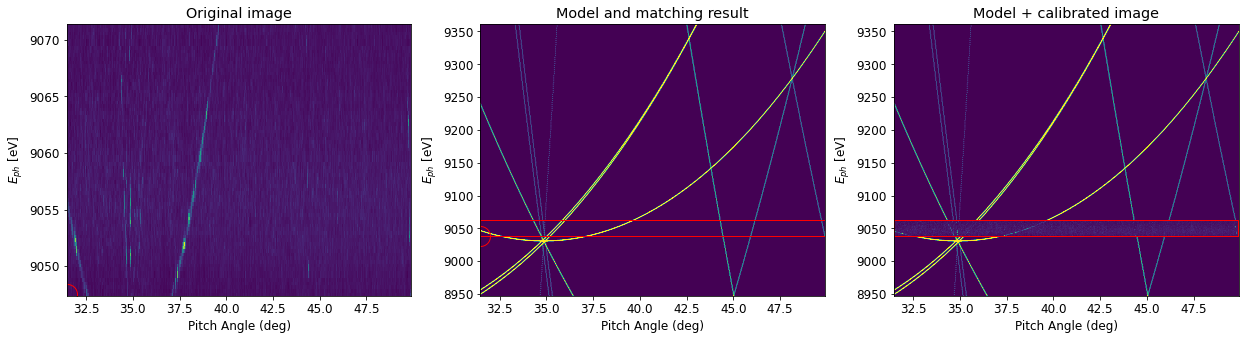

Monochromator 2 image found; from database: roll angle=1.1304 deg 

20210820-20_45_31_cor2d.npz
Original measured point 9024.02 eV
Matched model point 9021.43 eV
Template Matching Calibration -2.59 eV
Estimated Calibration (by visual inspection) -4.0 eV 



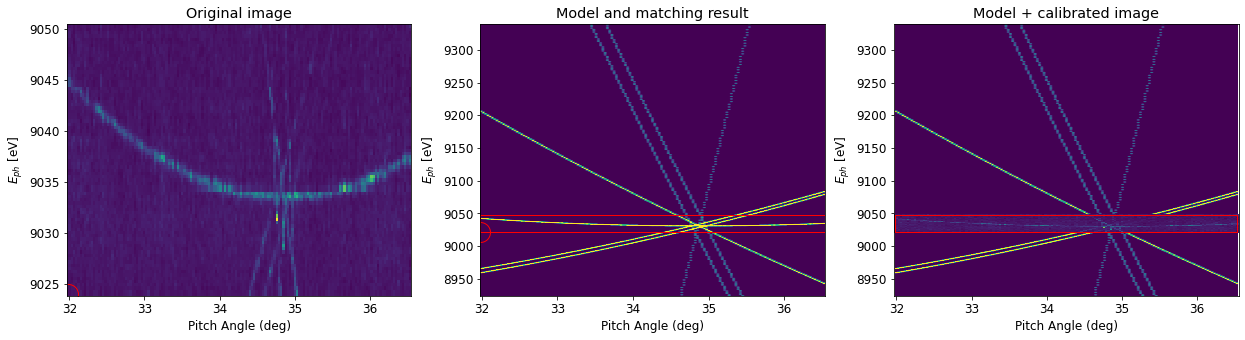

Monochromator 2 image found; from database: roll angle=1.13 deg 

20210821-12_27_24_cor2d.npz
Original measured point 9014.46 eV
Matched model point 9013.81 eV
Template Matching Calibration -0.65 eV
Estimated Calibration (by visual inspection) 0.0 eV 



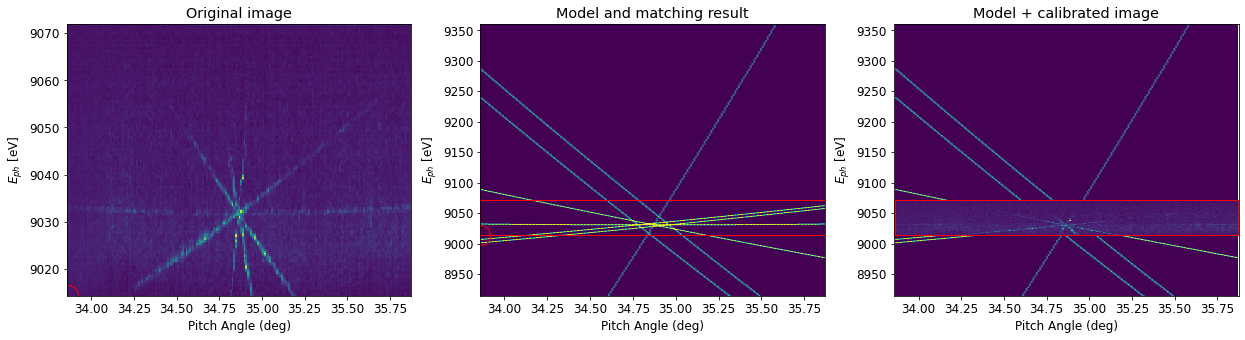

Monochromator 2 image found; from database: roll angle=1.5 deg 

20210821-12_43_08_cor2d.npz
Original measured point 9015.74 eV
Matched model point 9014.84 eV
Template Matching Calibration -0.9 eV
Estimated Calibration (by visual inspection) 0.0 eV 



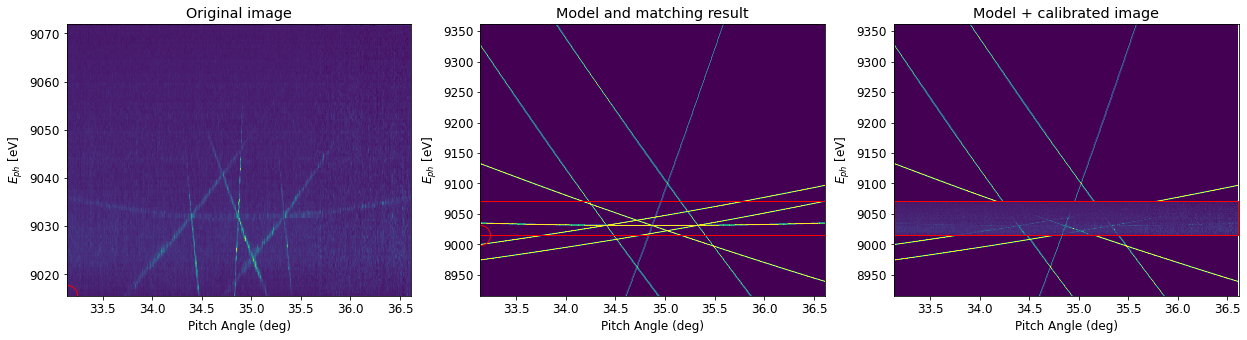

Monochromator 2 image found; 
Machine status file found: roll angle=1.5 deg 

20210914-11_04_42_cor2d.npz
Original measured point 8497.48 eV
Matched model point 8488.66 eV
Template Matching Calibration -8.82 eV
Estimated Calibration (by visual inspection) -7.0 eV 



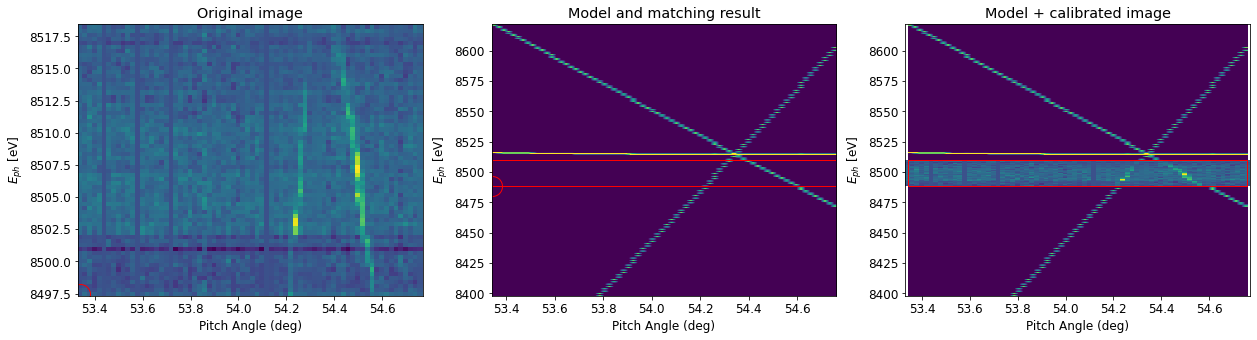

Monochromator 2 image found; 
Machine status file found: roll angle=1.5 deg 

20210914-11_06_53_cor2d.npz
Original measured point 8505.81 eV
Matched model point 8495.57 eV
Template Matching Calibration -10.24 eV
Estimated Calibration (by visual inspection) -7.0 eV 



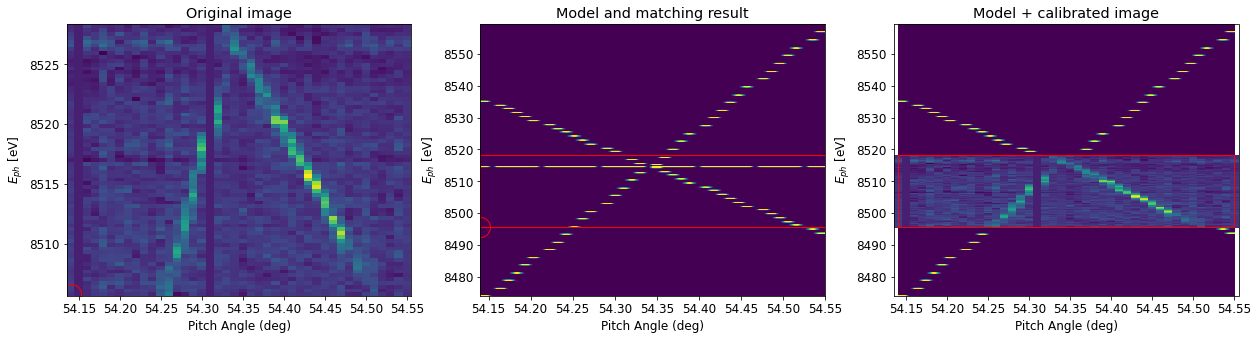

Monochromator 2 image found; 
Machine status file found: roll angle=1.5 deg 

20210914-11_14_08_cor2d.npz
Original measured point 8504.53 eV
Matched model point 8496.17 eV
Template Matching Calibration -8.36 eV
Estimated Calibration (by visual inspection) -7.0 eV 



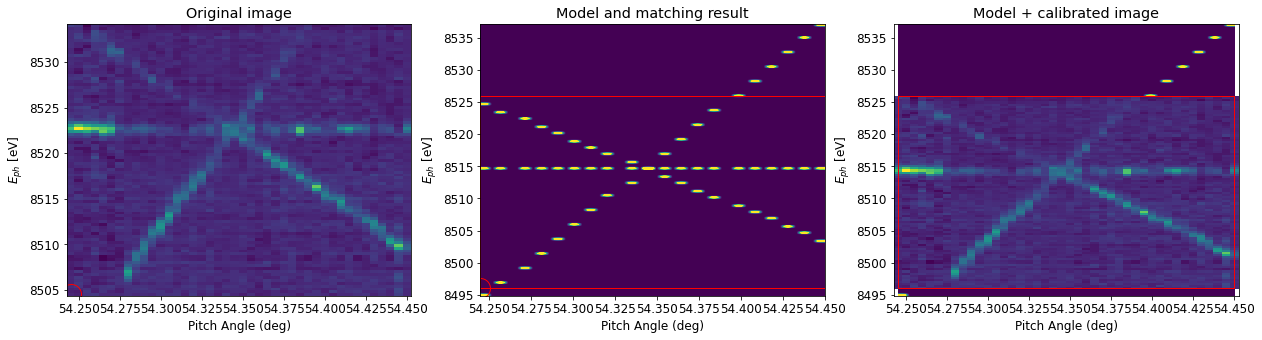

Monochromator 2 image found; 
Machine status file found: roll angle=1.5 deg 

20210914-12_38_54_cor2d.npz
Original measured point 6959.64 eV
Matched model point 7051.8 eV
Template Matching Calibration 92.16 eV
Estimated Calibration (by visual inspection) -7.0 eV 



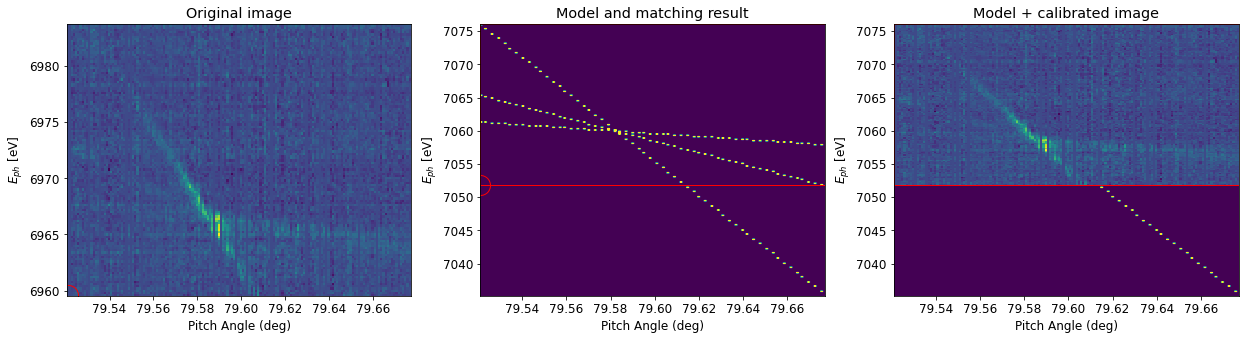

Monochromator 2 image found; 
Machine status file found: roll angle=1.5 deg 

20210925-17_40_18_cor2d.npz
Original measured point 13076.49 eV
Matched model point 13025.1 eV
Template Matching Calibration -51.39 eV
Estimated Calibration (by visual inspection) -62.0 eV 



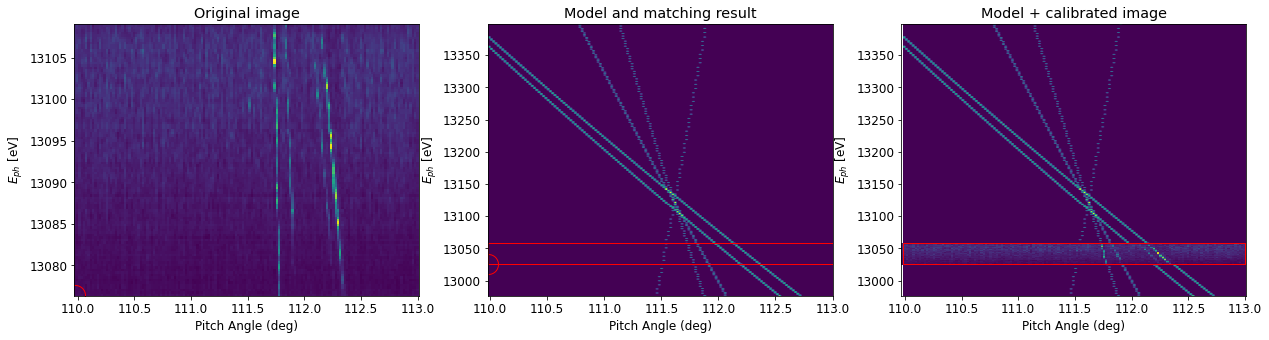

Monochromator 2 image found; 
Machine status file found: roll angle=1.58 deg 

20210925-20_02_02_cor2d.npz
Original measured point 12970.68 eV
Matched model point 13018.15 eV
Template Matching Calibration 47.47 eV
Estimated Calibration (by visual inspection) -62.0 eV 



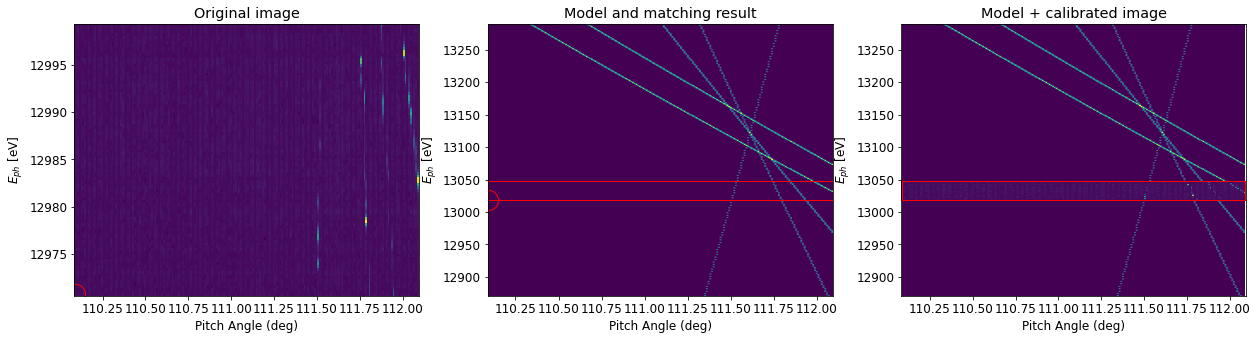

Monochromator 2 image found; 
Machine status file found: roll angle=1.58 deg 

20210925-22_04_34_cor2d.npz
Original measured point 13069.88 eV
Matched model point 13014.07 eV
Template Matching Calibration -55.81 eV
Estimated Calibration (by visual inspection) -62.0 eV 



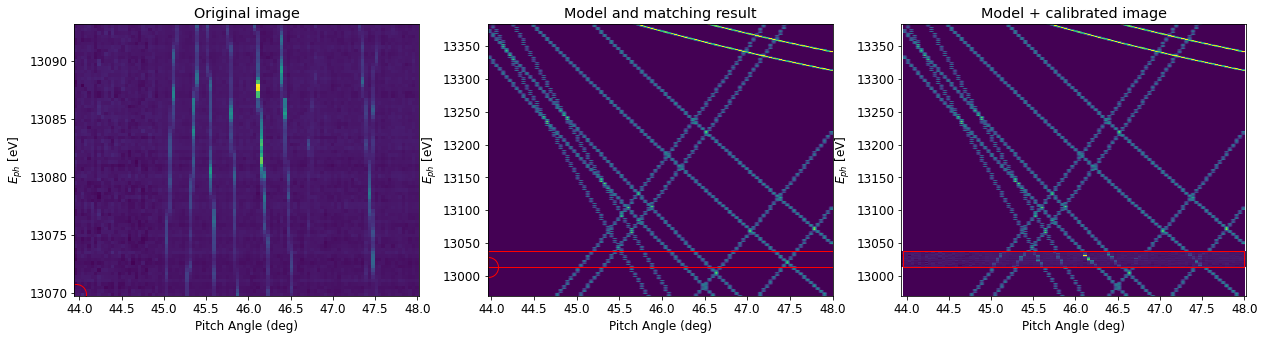

Monochromator 2 image found; 
Machine status file found: roll angle=1.08 deg 

20210925-22_43_34_cor2d.npz
Original measured point 13064.48 eV
Matched model point 13006.43 eV
Template Matching Calibration -58.05 eV
Estimated Calibration (by visual inspection) -62.0 eV 



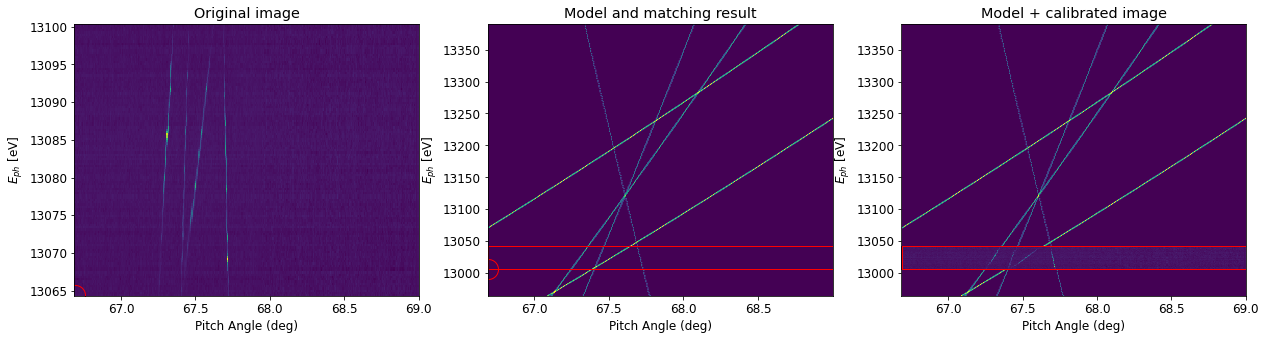

Monochromator 2 image found; 
Machine status file found: roll angle=1.58 deg 

20210925-22_49_43_cor2d.npz
Original measured point 13065.38 eV
Matched model point 13005.69 eV
Template Matching Calibration -59.69 eV
Estimated Calibration (by visual inspection) -62.0 eV 



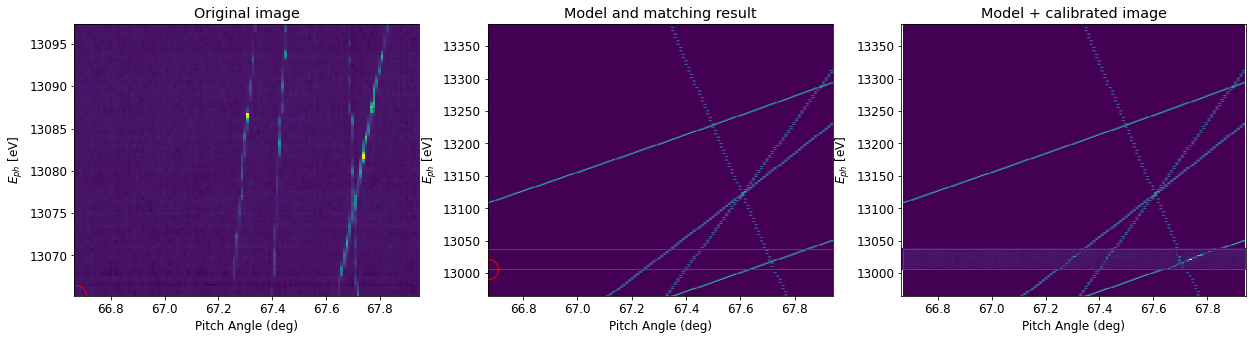

Monochromator 2 image found; 
Machine status file found: roll angle=1.58 deg 

20210926-18_17_10_cor2d.npz
Original measured point 12979.08 eV
Matched model point 13011.85 eV
Template Matching Calibration 32.77 eV
Estimated Calibration (by visual inspection) 20.0 eV 



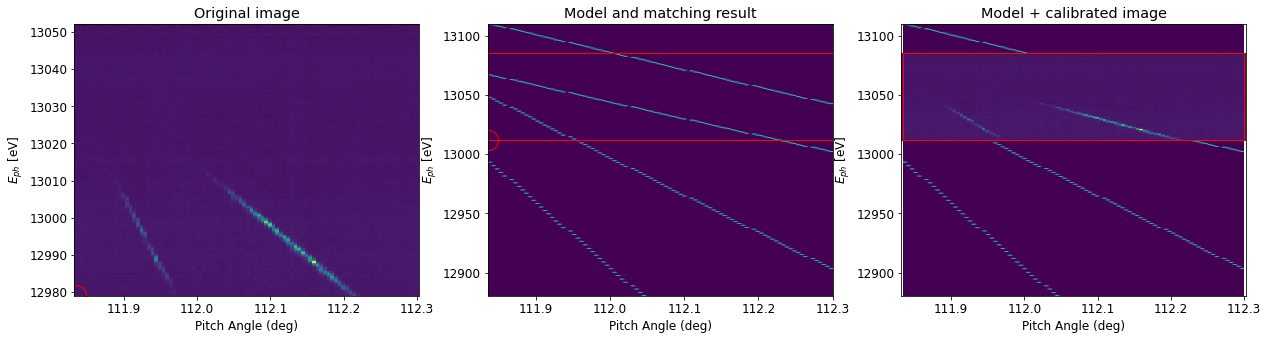

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-00_43_31_cor2d-Copy1.npz
Original measured point 12981.88 eV
Matched model point 13030.01 eV
Template Matching Calibration 48.13 eV
Estimated Calibration (by visual inspection) 40.0 eV 



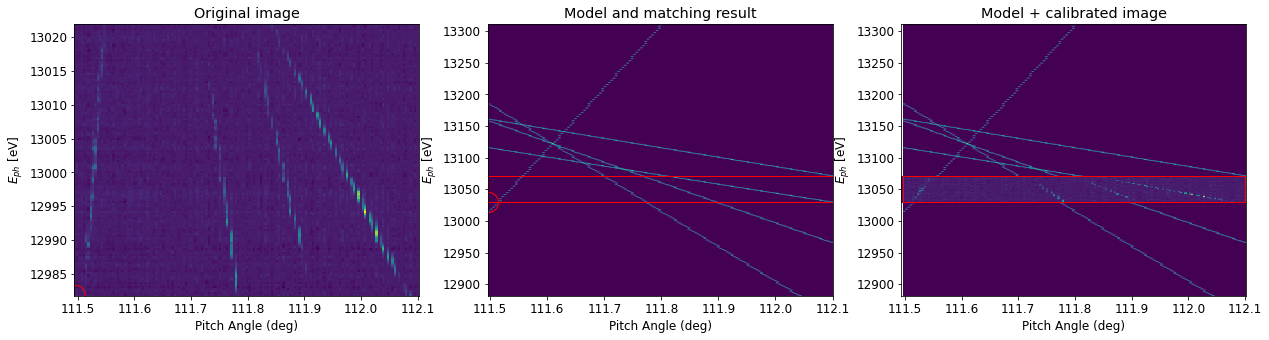

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-00_43_31_cor2d.npz
Original measured point 12981.88 eV
Matched model point 13030.01 eV
Template Matching Calibration 48.13 eV
Estimated Calibration (by visual inspection) 40.0 eV 



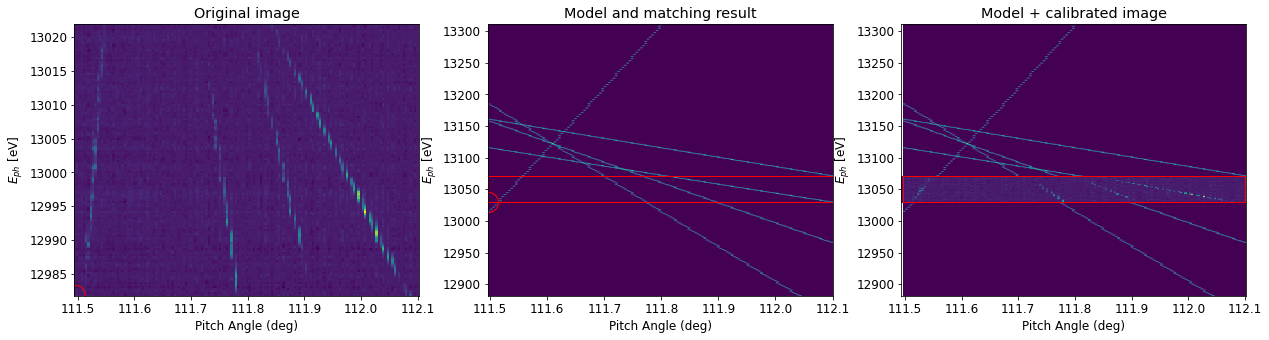

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-00_45_45_cor2d.npz
Original measured point 12981.77 eV
Matched model point 13028.88 eV
Template Matching Calibration 47.11 eV
Estimated Calibration (by visual inspection) 40.0 eV 



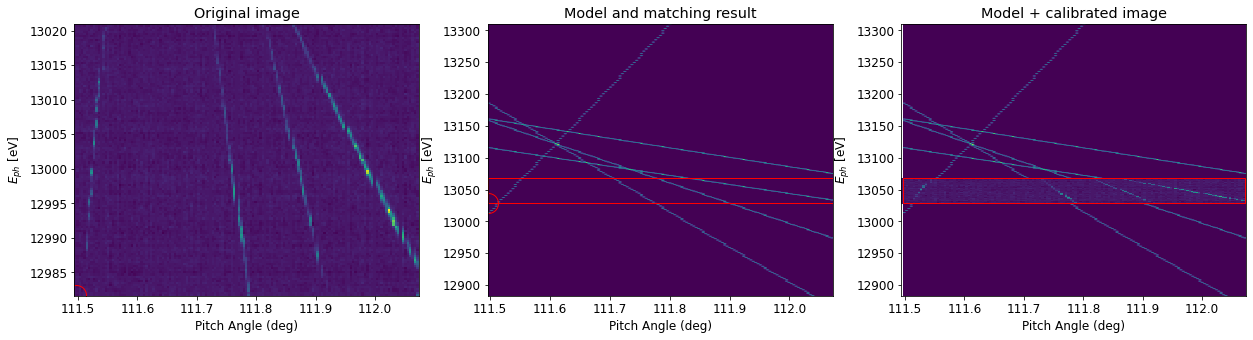

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-03_25_49_cor2d.npz
Original measured point 12927.8 eV
Matched model point 12951.12 eV
Template Matching Calibration 23.32 eV
Estimated Calibration (by visual inspection) 10.0 eV 



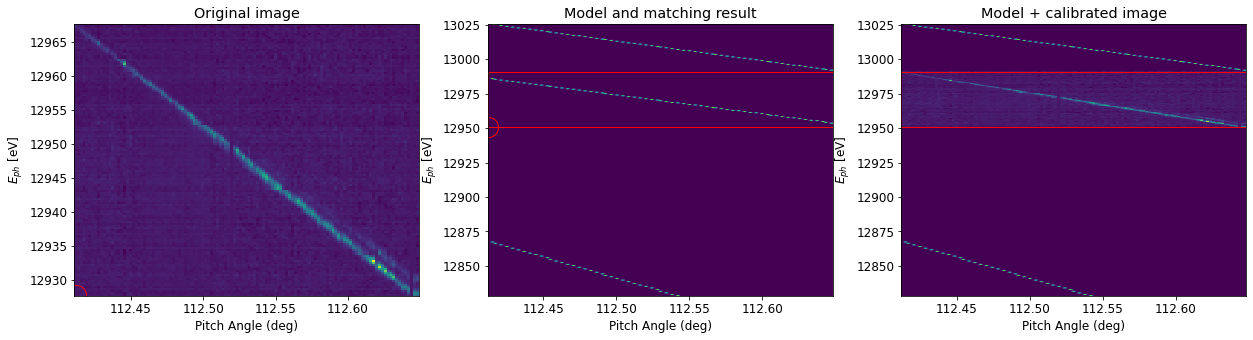

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-03_29_01_cor2d.npz
Original measured point 12925.1 eV
Matched model point 12947.96 eV
Template Matching Calibration 22.86 eV
Estimated Calibration (by visual inspection) 10.0 eV 



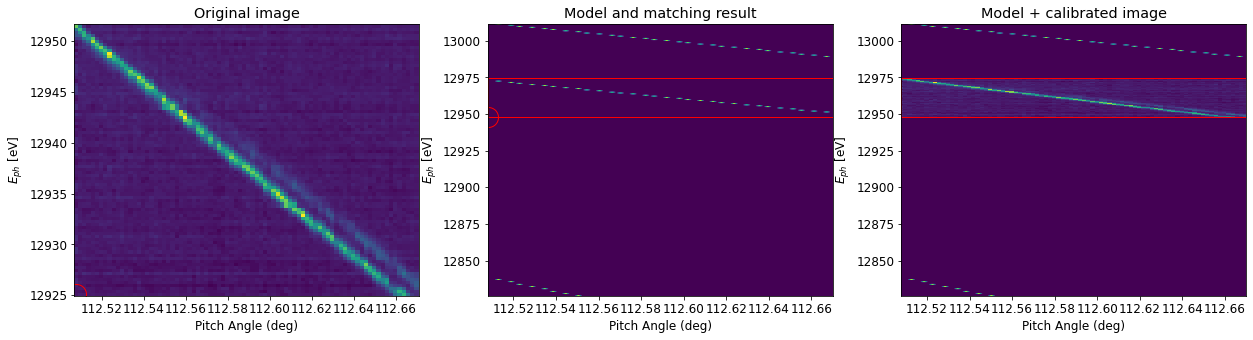

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-15_13_19_cor2d.npz
Original measured point 12877.02 eV
Matched model point 12776.78 eV
Template Matching Calibration -100.24 eV
Estimated Calibration (by visual inspection) 10.0 eV 



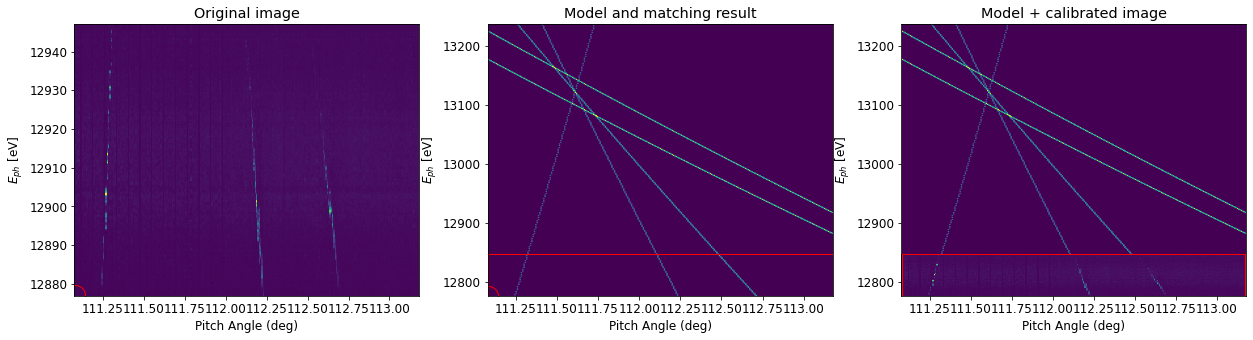

Monochromator 2 image found; 
Machine status file found: roll angle=1.5801 deg 

20211006-15_41_51_cor2d.npz
Original measured point 12957.18 eV
Matched model point 12877.34 eV
Template Matching Calibration -79.84 eV
Estimated Calibration (by visual inspection) 10.0 eV 



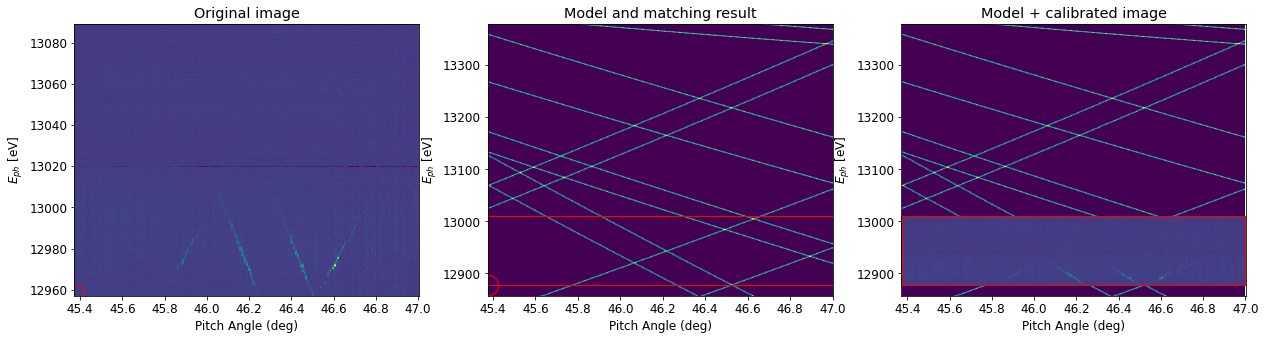

Monochromator 2 image found; 
Machine status file found: roll angle=1.509 deg 

20211006-15_45_05_cor2d.npz
Original measured point 12962.89 eV
Matched model point 12881.14 eV
Template Matching Calibration -81.75 eV
Estimated Calibration (by visual inspection) 10.0 eV 



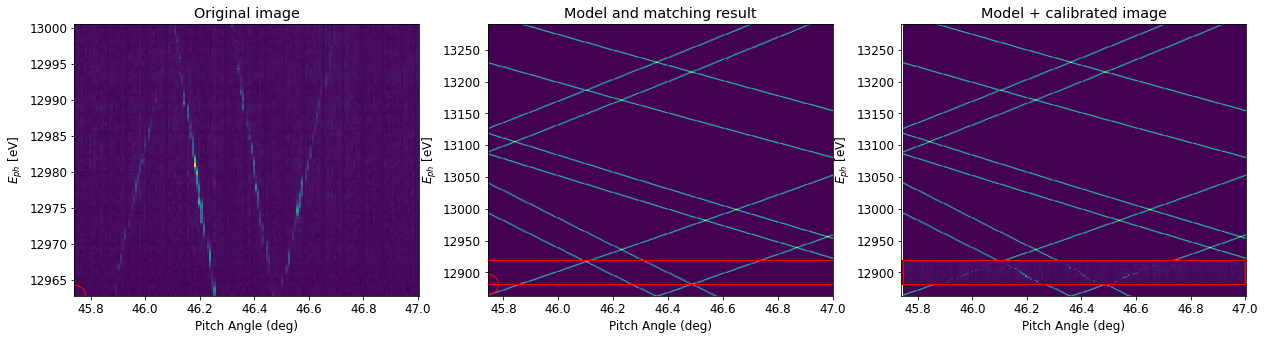

Monochromator 2 image found; 
Machine status file found: roll angle=1.309 deg 

20211006-15_46_29_cor2d.npz
Original measured point 12965.89 eV
Matched model point 12885.37 eV
Template Matching Calibration -80.52 eV
Estimated Calibration (by visual inspection) 10.0 eV 



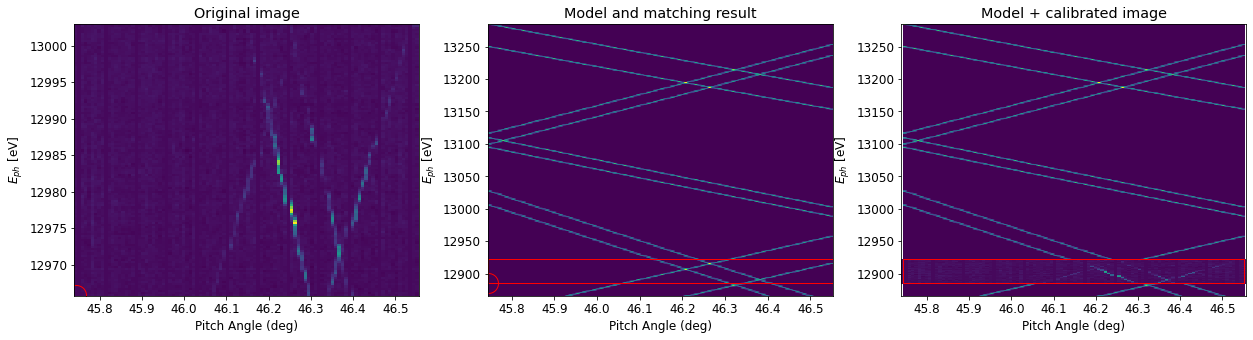

Monochromator 2 image found; 
Machine status file found: roll angle=1.0 deg 

20211006-15_49_22_cor2d.npz
Original measured point 12962.29 eV
Matched model point 12882.74 eV
Template Matching Calibration -79.55 eV
Estimated Calibration (by visual inspection) 10.0 eV 



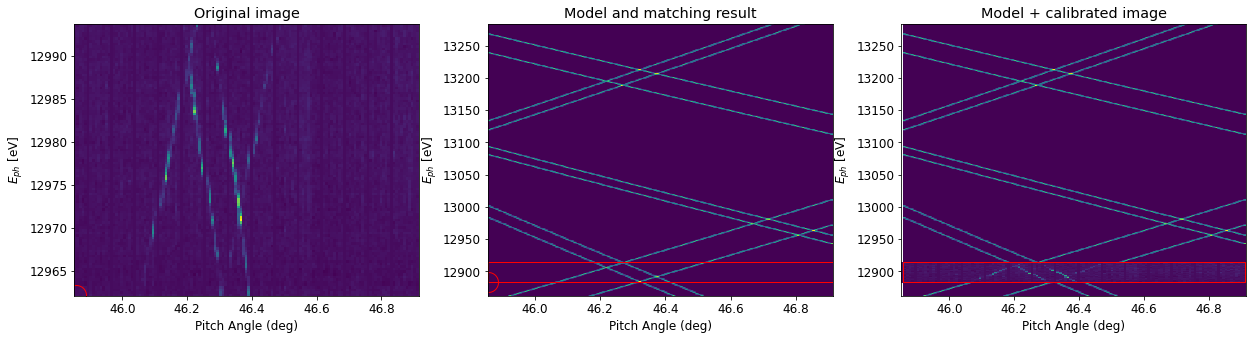

Monochromator 2 image found; 
Machine status file found: roll angle=0.9 deg 

20211006-15_50_40_cor2d.npz
Original measured point 12963.79 eV
Matched model point 12883.49 eV
Template Matching Calibration -80.3 eV
Estimated Calibration (by visual inspection) 10.0 eV 



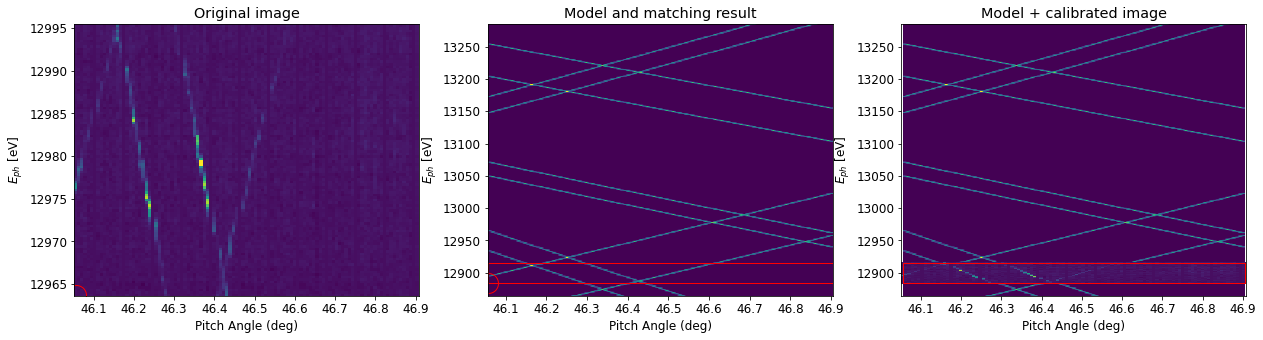

Monochromator 2 image found; 
Machine status file found: roll angle=1.1 deg 

20211006-15_51_52_cor2d.npz
Original measured point 12960.49 eV
Matched model point 12877.52 eV
Template Matching Calibration -82.97 eV
Estimated Calibration (by visual inspection) 10.0 eV 



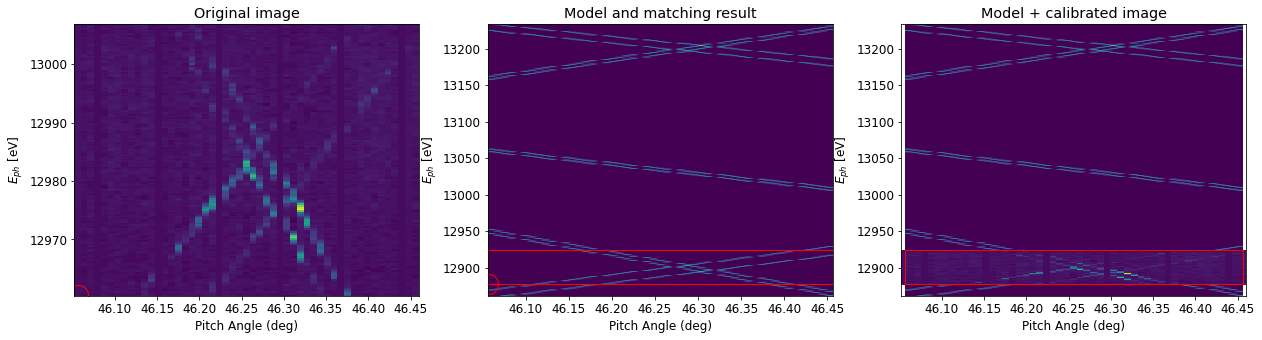

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211101-17_34_06_cor2d.npz
Original measured point 11575.8 eV
Matched model point 11721.16 eV
Template Matching Calibration 145.36 eV
Estimated Calibration (by visual inspection) 100.0 eV 



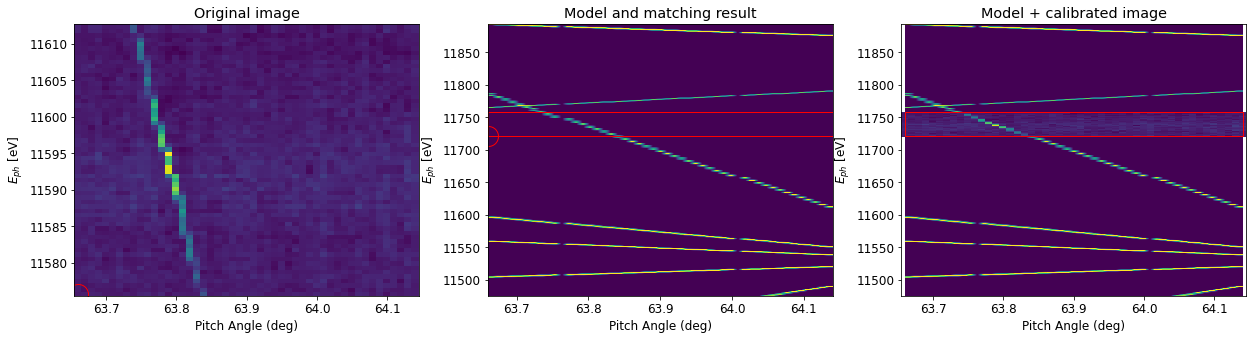

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211101-19_35_30_cor2d.npz
Original measured point 11562.59 eV
Matched model point 11707.62 eV
Template Matching Calibration 145.03 eV
Estimated Calibration (by visual inspection) 100.0 eV 



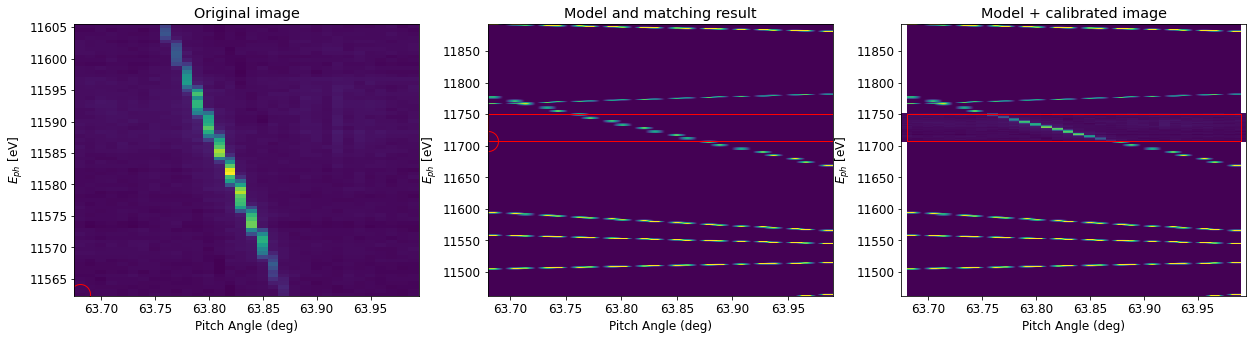

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-09_17_16_cor2d.npz
Original measured point 11486.81 eV
Matched model point 11478.74 eV
Template Matching Calibration -8.07 eV
Estimated Calibration (by visual inspection) 100.0 eV 



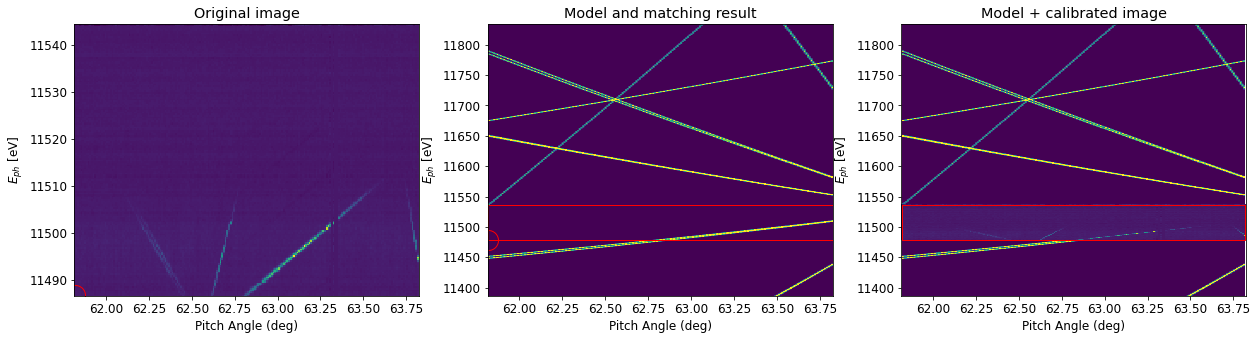

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-09_31_44_cor2d.npz
Original measured point 11493.82 eV
Matched model point 11485.76 eV
Template Matching Calibration -8.05 eV
Estimated Calibration (by visual inspection) 100.0 eV 



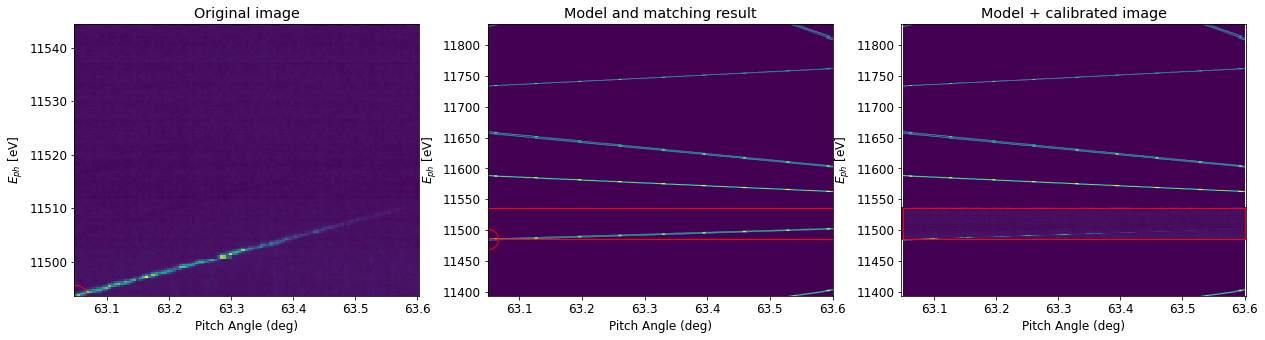

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-09_45_35_cor2d.npz
Original measured point 11484.71 eV
Matched model point 11722.13 eV
Template Matching Calibration 237.42 eV
Estimated Calibration (by visual inspection) 100.0 eV 



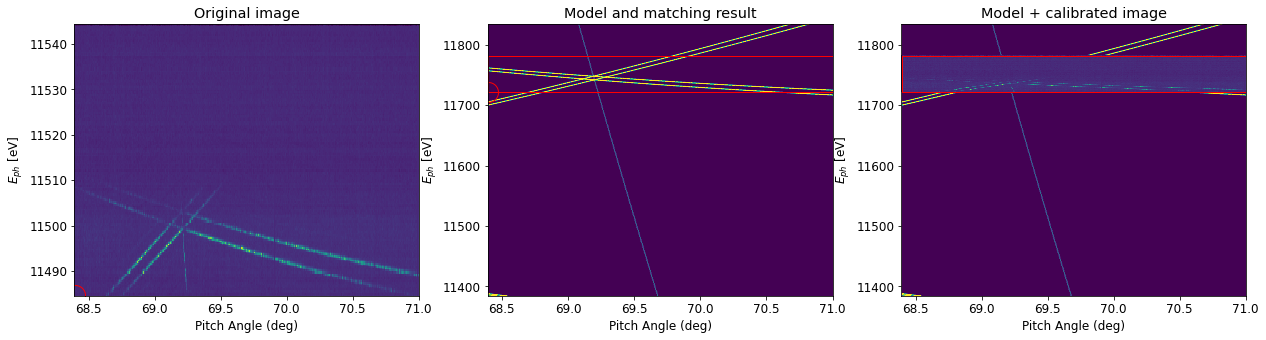

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-10_48_36_cor2d.npz
Original measured point 11615.98 eV
Matched model point 11715.39 eV
Template Matching Calibration 99.4 eV
Estimated Calibration (by visual inspection) 100.0 eV 



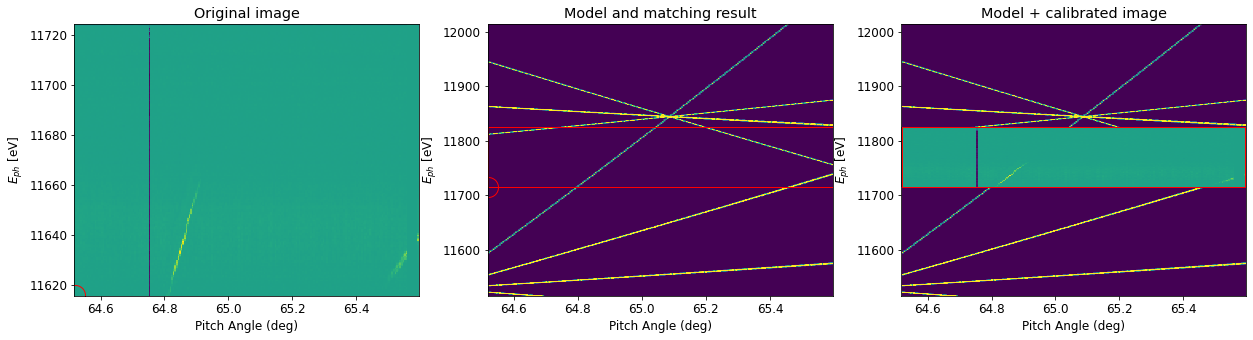

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-10_50_24_cor2d.npz
Original measured point 11620.79 eV
Matched model point 11709.49 eV
Template Matching Calibration 88.71 eV
Estimated Calibration (by visual inspection) 100.0 eV 



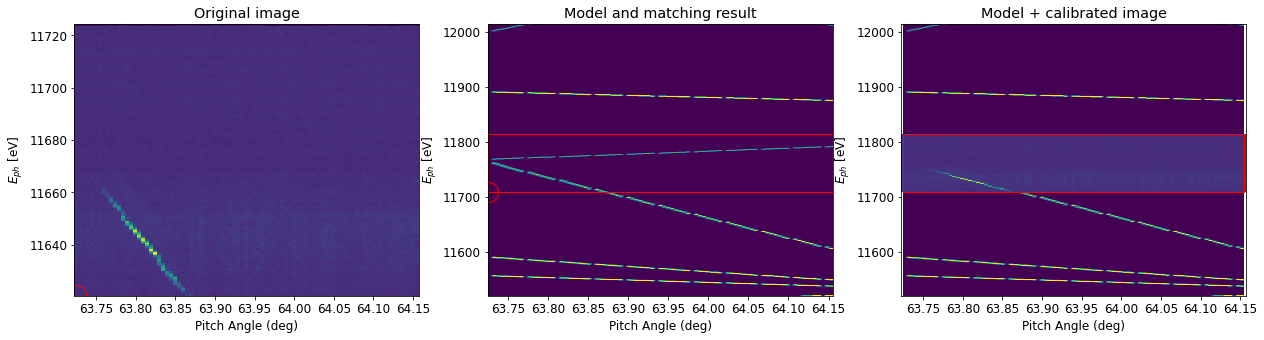

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-10_53_45_cor2d.npz
Original measured point 11625.59 eV
Matched model point 11723.11 eV
Template Matching Calibration 97.52 eV
Estimated Calibration (by visual inspection) 100.0 eV 



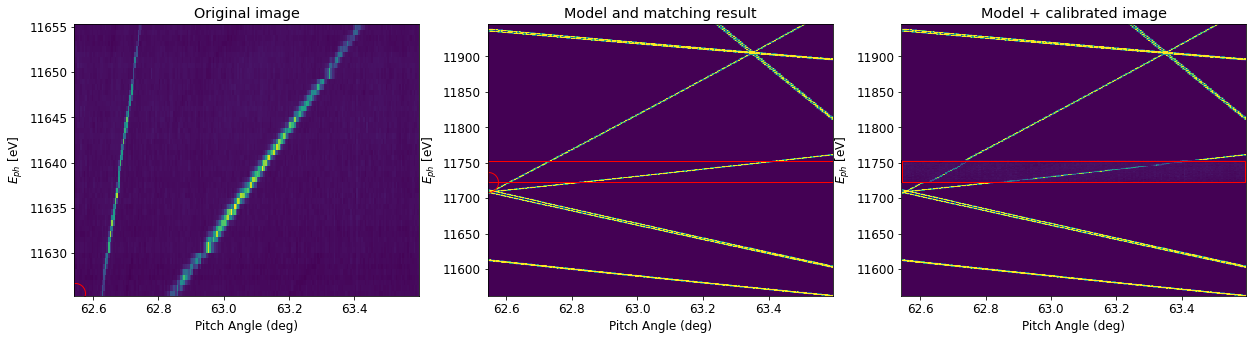

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-11_03_49_cor2d.npz
Original measured point 11630.99 eV
Matched model point 11724.72 eV
Template Matching Calibration 93.72 eV
Estimated Calibration (by visual inspection) 100.0 eV 



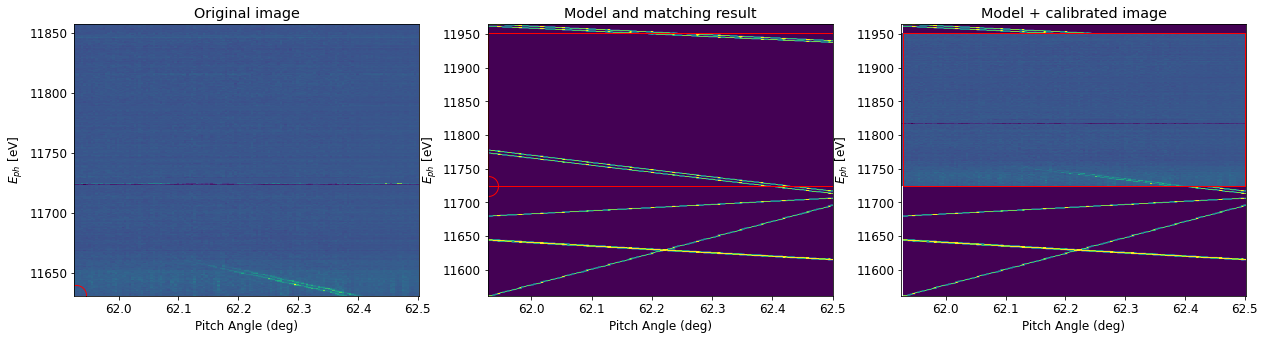

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-11_06_06_cor2d.npz
Original measured point 11624.39 eV
Matched model point 11721.73 eV
Template Matching Calibration 97.34 eV
Estimated Calibration (by visual inspection) 100.0 eV 



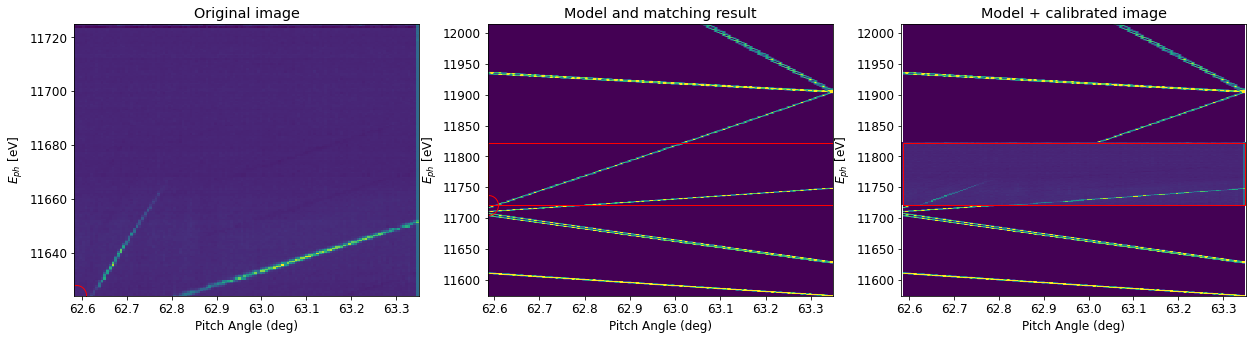

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-12_51_08_cor2d.npz
Original measured point 11623.19 eV
Matched model point 11717.18 eV
Template Matching Calibration 93.99 eV
Estimated Calibration (by visual inspection) 100.0 eV 



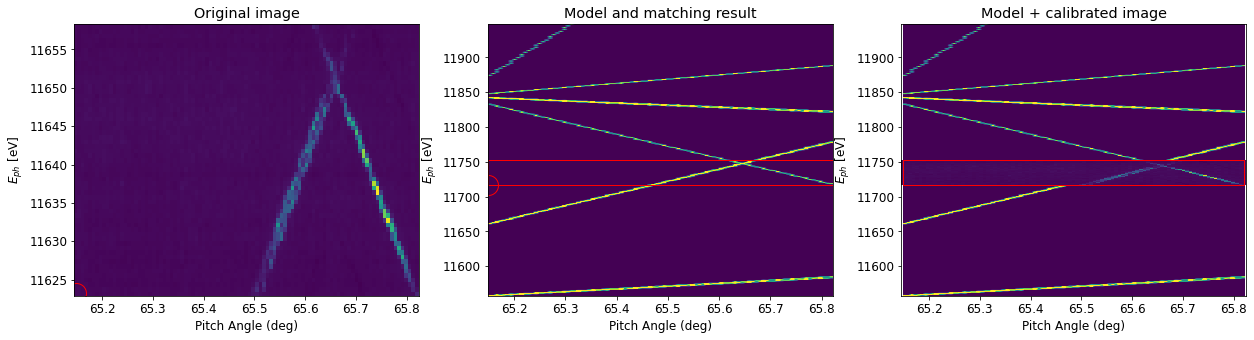

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-12_51_48_cor2d.npz
Original measured point 11618.38 eV
Matched model point 11712.67 eV
Template Matching Calibration 94.28 eV
Estimated Calibration (by visual inspection) 100.0 eV 



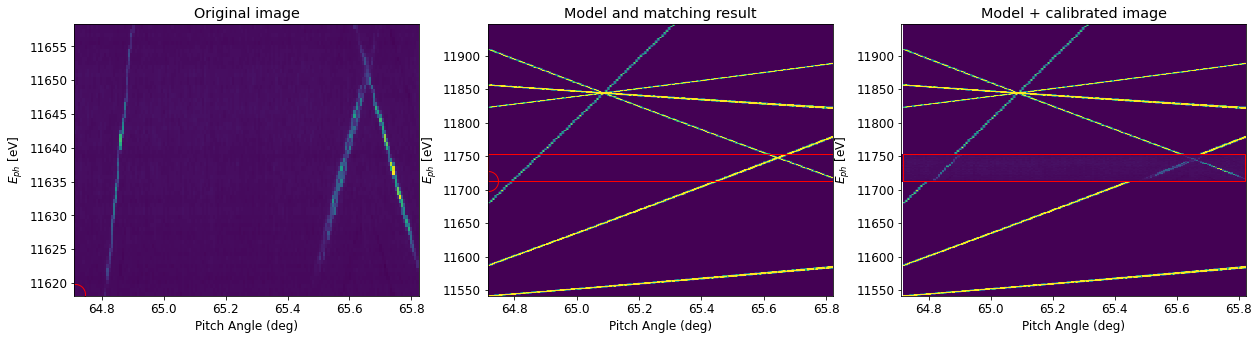

Monochromator 2 image found; 
Machine status file found: roll angle=1.2677 deg 

20211102-12_54_53_cor2d.npz
Original measured point 11623.79 eV
Matched model point 11720.82 eV
Template Matching Calibration 97.03 eV
Estimated Calibration (by visual inspection) 100.0 eV 



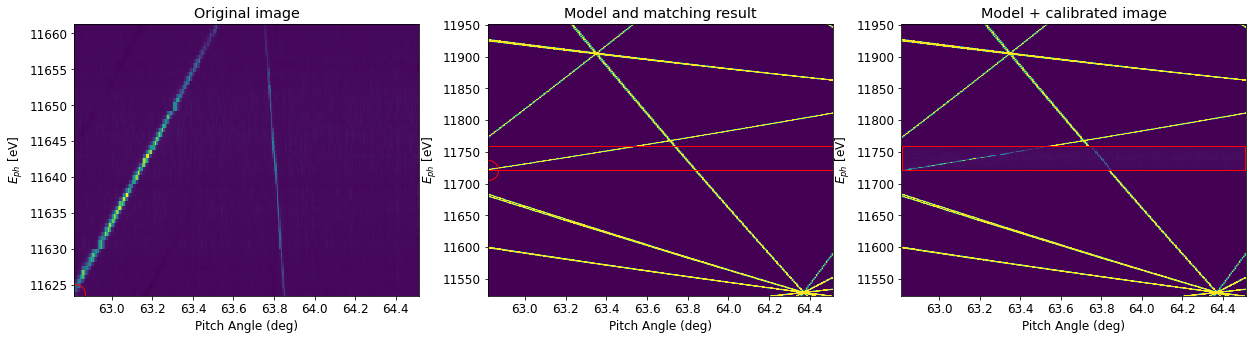

Monochromator 1 image found; 
Machine status file found: roll angle=0.8363 deg 

20220301-17_33_19_cor2d.npz
Original measured point 5959.46 eV
Matched model point 5960.79 eV
Template Matching Calibration 1.34 eV
Estimated Calibration (by visual inspection) -35.0 eV 



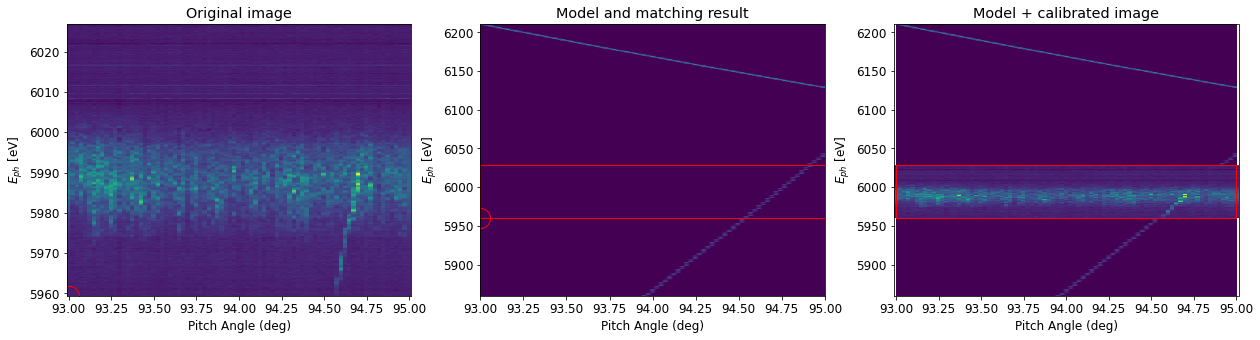

Monochromator 1 image found; 
Machine status file found: roll angle=0.8 deg 

20220301-23_10_18_cor2d.npz
Original measured point 5971.94 eV
Matched model point 5977.64 eV
Template Matching Calibration 5.7 eV
Estimated Calibration (by visual inspection) 10.0 eV 



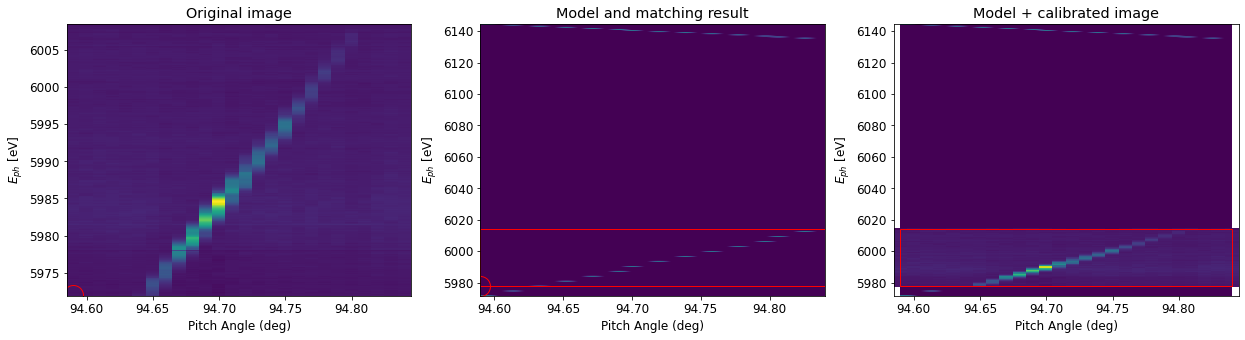

Monochromator 1 image found; 
Machine status file found: roll angle=0.8 deg 

20220301-23_10_35_cor2d.npz
Original measured point 5971.94 eV
Matched model point 5977.64 eV
Template Matching Calibration 5.7 eV
Estimated Calibration (by visual inspection) 10.0 eV 



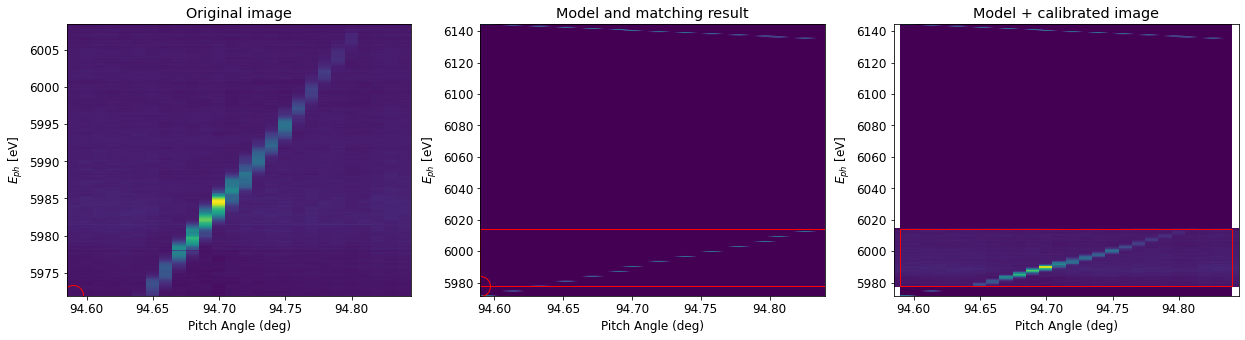

Monochromator 1 image found; 
Machine status file found: roll angle=0.8 deg 

20220301-23_21_14_cor2d.npz
Original measured point 5971.94 eV
Matched model point 5977.64 eV
Template Matching Calibration 5.7 eV
Estimated Calibration (by visual inspection) 10.0 eV 



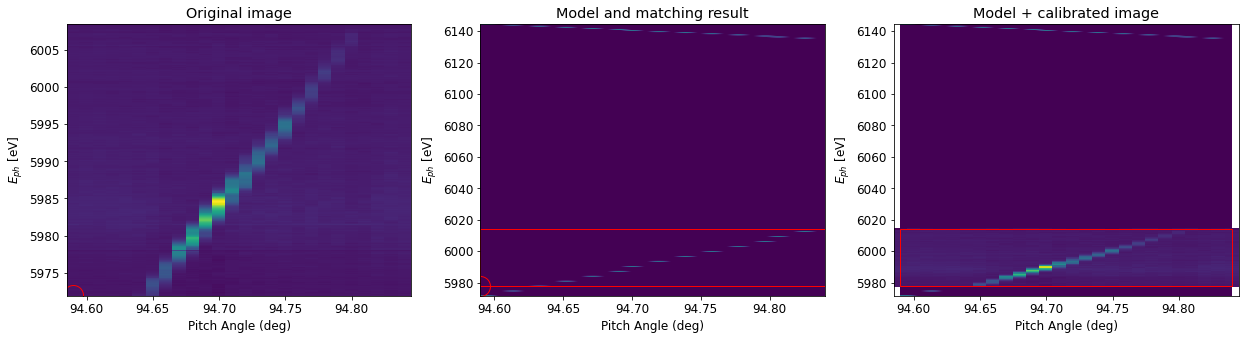

Monochromator 2 image found; 
Machine status file found: roll angle=1.2802 deg 

20220302-06_08_35_cor2d.npz
Original measured point 5973.75 eV
Matched model point 5944.17 eV
Template Matching Calibration -29.57 eV
Estimated Calibration (by visual inspection) -35.0 eV 



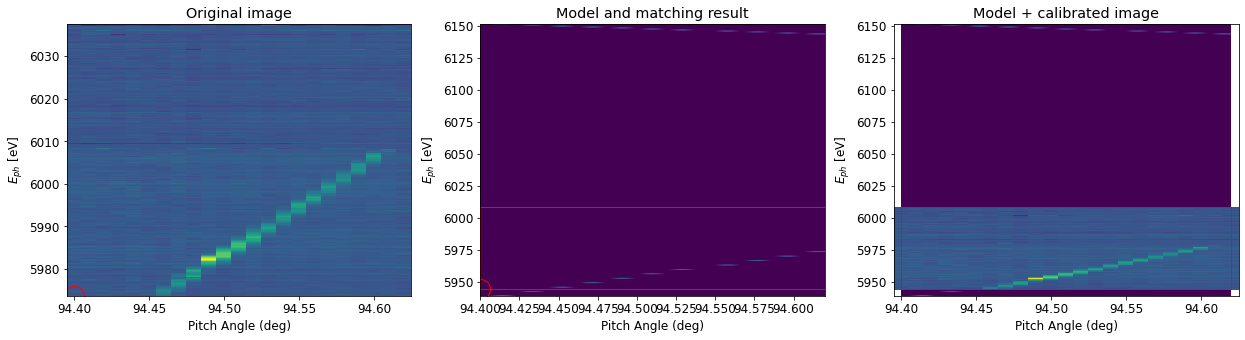

Monochromator 2 image found; 
Machine status file found: roll angle=1.2802 deg 

20220302-06_10_11_cor2d.npz
Original measured point 5973.87 eV
Matched model point 5944.29 eV
Template Matching Calibration -29.57 eV
Estimated Calibration (by visual inspection) -35.0 eV 



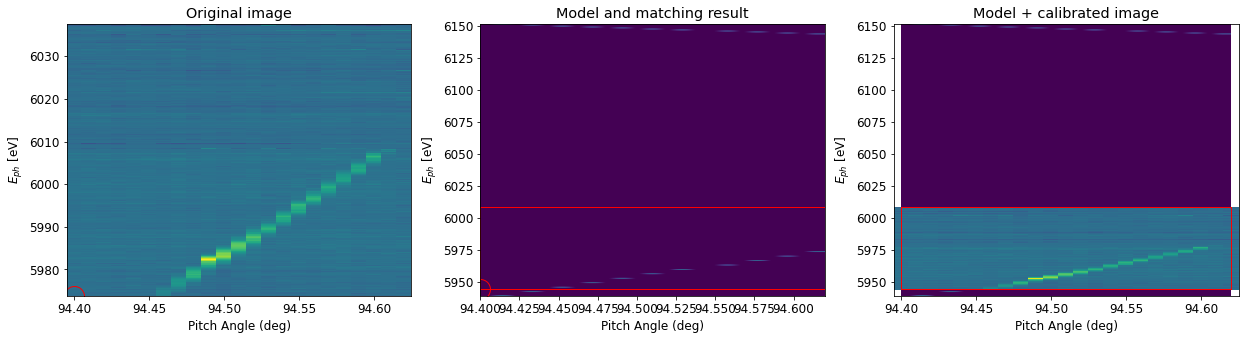

Monochromator 2 image found; 
Machine status file found: roll angle=1.2802 deg 

20220328-12_28_10_cor2d.npz
Original measured point 8941.85 eV
Matched model point 8884.98 eV
Template Matching Calibration -56.87 eV
Estimated Calibration (by visual inspection) 65.0 eV 



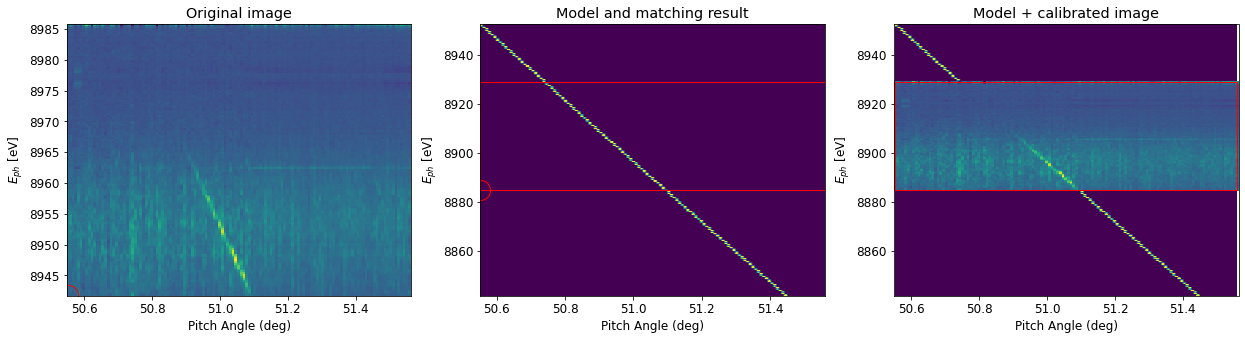

Monochromator 2 image found; 
Machine status file found: roll angle=1.2802 deg 

20220328-12_36_37_cor2d.npz
Original measured point 8938.54 eV
Matched model point 8881.58 eV
Template Matching Calibration -56.97 eV
Estimated Calibration (by visual inspection) 65.0 eV 



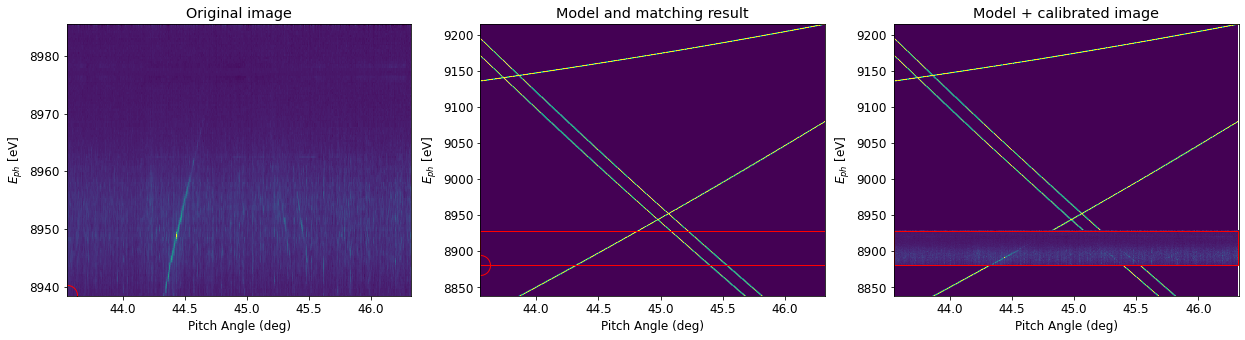

Monochromator 2 image found; 
Machine status file found: roll angle=1.2802 deg 

20220328-12_58_59_cor2d.npz
Original measured point 8922.63 eV
Matched model point 8985.73 eV
Template Matching Calibration 63.1 eV
Estimated Calibration (by visual inspection) 65.0 eV 



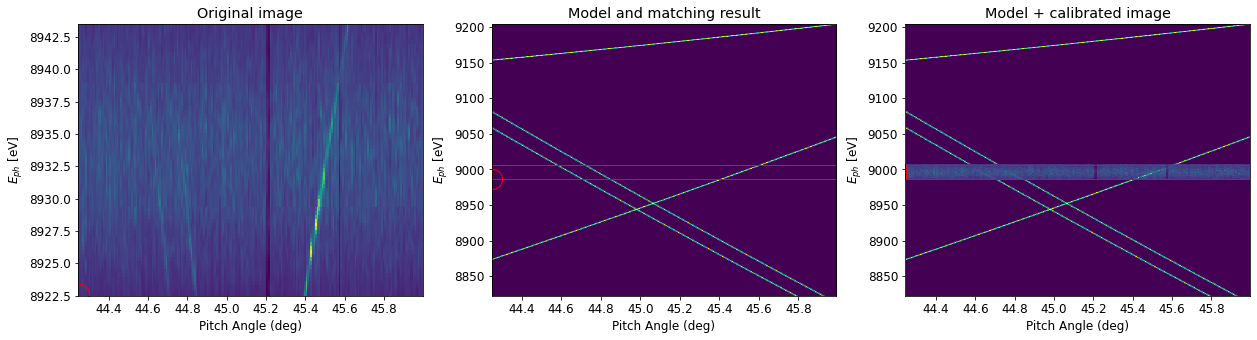

Monochromator 2 image found; 
Machine status file found: roll angle=1.2802 deg 

20220328-13_02_15_cor2d.npz
Original measured point 8923.23 eV
Matched model point 8986.33 eV
Template Matching Calibration 63.09 eV
Estimated Calibration (by visual inspection) 65.0 eV 



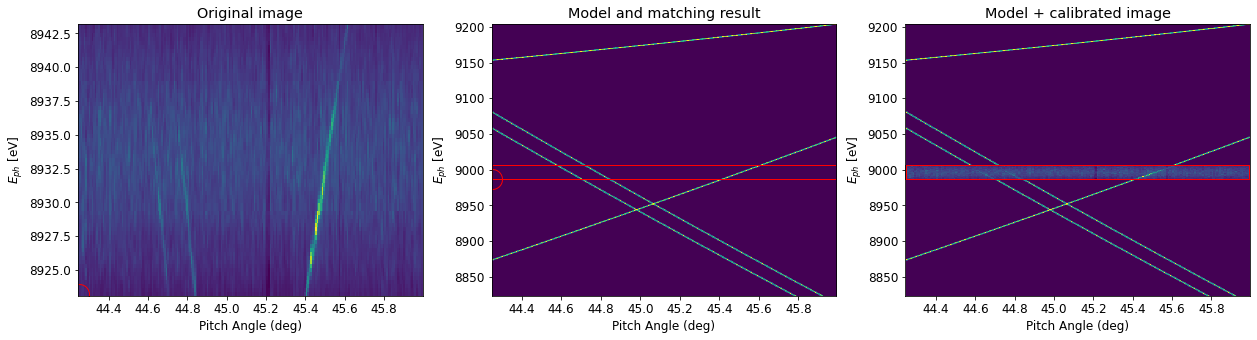

In [129]:
for filename in sorted(os.listdir(directory)):
    if filename.endswith(".npz"):
        filepath=os.path.join(directory, filename)
        tt = np.load(filepath)
        corr2d = tt['corr2d']
        orig_image = tt['corr2d']
        spec_hist = tt['spec_hist']
        doocs_scale = tt['doocs_scale'] 
        phen_scale = tt['phen_scale']
        doocs_label = tt['doocs_channel']
        # check if the image corresponds to a crystal pitch angle scan. MONOPA 
        if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label or "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
            date_raw=filename[ 0 : 17 ]
            date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
            m=m+1
            # Search for corresponding roll angle from the status file or the database pickle file.
            if "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2252.SA2/ANGLE" in doocs_label: 
                mono_no_pitch = 1
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2252.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 1 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 1 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 1 image found; Default roll angle set (1 deg).')
            elif "XFEL.FEL/UNDULATOR.SASE2/MONOPA.2307.SA2/ANGLE" in doocs_label:
                mono_no_pitch = 2
                try:
                    filedata = np.loadtxt(
                        filepath+'_status.txt', dtype='str', delimiter=',', skiprows=1)
                    ra_pos = np.where(
                        filedata == 'XFEL.FEL/UNDULATOR.SASE2/MONORA.2307.SA2/ANGLE')
                    ra_row = ra_pos[0][0]
                    roll_angle = float(filedata[ra_row][1])
                    print('Monochromator 2 image found; \nMachine status file found: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                except:
                    try:
                        berlin = pytz.timezone('Europe/Berlin')
                        df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                        df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                        dt = date_time_obj
                        dt = dt.replace(tzinfo=berlin)
                        roll = df_db['roll_angle'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                        roll_angle = float(roll.iloc[0])
                        print('Monochromator 2 image found; from database: roll angle=' + str(np.round(roll_angle, 4)) + ' deg \n')
                    except:
                        roll_angle = 1
                        print('Monochromator 2 image found; Default roll angle set (1 deg).')

            else: 
                mono_no_pitch = 0    
                
            if len(doocs_scale) != len(corr2d):
                np_doocs=doocs_scale[:-1]
            else:
                np_doocs=doocs_scale
            np_phen=phen_scale
            # Calculate energy and pitch angle resolutions
            phen_res=np_phen[2]-np_phen[1]
            angle_res_p=np_doocs[2]-np_doocs[1]
            
            # Threshold the image so that the image can be clipped
            orig_image=orig_image.T
            corr2d[corr2d < 0] = 0  # all values below 0 threshold are set to 0
            thresh = threshold_yen(orig_image, nbins=256)
            binary = orig_image > thresh
            processed_image = binary
           
            
            # Filter out the pixels labelled '0' and keep the pixels labelled '1' and create a dataframe
            df = pd.DataFrame(data=processed_image.T).astype(int)  # Convert image values from BOOL to INT
            df_scale = pd.DataFrame(data=np_doocs)
            df_scale.columns = ['parameter']
            df_phen = pd.DataFrame(data=np_phen)
            df_phen.columns = ['value']
            df_phen = df_phen.T
            df = pd.concat([df, df_phen])
            df.columns = df.iloc[-1]
            df.drop(df.tail(1).index,inplace=True)
            df=df.join(df_scale, lsuffix='caller', rsuffix='other')
            df.set_index('parameter', inplace=True)
            df1 = df.stack().reset_index()
            #set column names
            df1.columns = ['Parameter','Energy','Correlation']
            df2 = df1[df1['Correlation'] != False]
            df2=df2.drop(columns=['Correlation'])
            
            # Min and max energies after clipping
            min_phen = min(df2['Energy'])
            max_phen = max(df2['Energy'])
            
            #print(min_phen, max_phen)
            # Create a mask with these two energies so that the image can be clipped
            mask = (np_phen > min_phen) & (np_phen < max_phen)
 
            # making new array based on mask
            phen_clipped = np_phen[mask]
            
            #### MODEL image generation
            phen_list, p_angle_list, gid_list, linestyle_list, color_list = Bragg_plotter_limit(hmax, kmax, lmax, dthp, dthy, dthr, alpha, roll_angle, min(doocs_scale)-1, max(doocs_scale)+1, len(np_doocs)*5)
            ph_axis, pa_axis = [], []
            for phen, pangle, gid in zip(phen_list, p_angle_list, gid_list):
                for ph_value, pa_value in zip(phen, pangle):
                    # Only keep photon energies within a close range of the spectrometer image range
                    if ph_value > min_phen-100 and ph_value < max_phen+290 and pa_value >= min(doocs_scale) and pa_value <= max(doocs_scale):
                        ph_axis.append(ph_value)
                        pa_axis.append(pa_value)
            
            # Create arrays
            x = np.array(pa_axis)
            y = np.array(ph_axis)
            ph_range = abs(min(ph_axis)-max(ph_axis))
            # calculate how many pixels are required for the model image so that each pixel has the same resolution as the spectrometer image
            phbins = int(ph_range/phen_res)
            

            
            
            fig, (ax, ax1, ax4) = plt.subplots(1, 3, figsize=(21, 5))
            #fig.suptitle(filename, fontsize=11)

            #plot = ax0.pcolormesh(np_doocs, np_phen, orig_image, cmap='viridis', shading='auto')
            #ax0.set_title('Original image')
            #ax0.set_xlabel('Pitch Angle (deg)')
            #ax0.set_ylabel(r'$E_{ph}$ [eV]')
                
            plot = ax.pcolormesh(np_doocs, phen_clipped, orig_image[mask], cmap='viridis', shading='auto')
            ax.plot(np_doocs[0], phen_clipped[0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=20)
            ax.set_title('Original image')
            ax.set_xlabel('Pitch Angle (deg)')
            ax.set_ylabel(r'$E_{ph}$ [eV]')
                
                
            meas = orig_image[mask]
            model = heatmap.T
            
            # Match Template
            try:
                result = match_template(model, meas, pad_input=False)
                ij = np.unravel_index(np.argmax(result), result.shape)
                x, y = ij[::-1]
                #print('Image shape', model.shape)
                #print('Template shape', meas.shape)
                print(filename)
            
                #ax2.pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto')
                ax1.imshow(model, extent=extent, origin='lower', aspect='auto', vmin=0., vmax=0.5)
                ax1.set_title('Model and matching result')
                # highlight matched region
                hmeas, wmeas = meas.shape   # Shape of spectrometer image in pixels
                rect = plt.Rectangle((xedges[0]+(model_pares*x), yedges[0]+(model_phres*y)), model_parange, (hmeas*phen_res), edgecolor='r', facecolor='none')
                ax1.plot((x*model_pares)+xedges[0], (y*model_phres)+yedges[0], 'o', markeredgecolor='r', markerfacecolor='none', markersize=20)
                ax1.add_patch(rect)
                ax1.set_xlabel('Pitch Angle (deg)')
                ax1.set_ylabel(r'$E_{ph}$ [eV]')

                #ax3.imshow(result, origin='lower', aspect='auto', interpolation='bilinear')
                #ax3.set_title('`match_template`\nresult')
                # highlight matched region
                #ax3.autoscale(False)
                #ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)


                calibrated_point = yedges[0]+(model_phres*y)
                orig_point = phen_clipped[0]

                print('Original measured point',  np.round(orig_point,2), 'eV')
                print('Matched model point',  np.round(calibrated_point,2), 'eV')
                print('Template Matching Calibration', np.round(calibrated_point-orig_point, 2), 'eV')

                try:
                    date_raw=filename[ 0 : 17 ]
                    date_time_obj = datetime.strptime(date_raw, '%Y%m%d-%H_%M_%S') #strip date from image filename
                    berlin = pytz.timezone('Europe/Berlin')
                    df_db['date_full'] = pd.to_datetime(df_db['date_full'], utc=True)
                    df_db['date_full'] = df_db['date_full'].dt.tz_convert("Europe/Paris")
                    dt = date_time_obj
                    dt = dt.replace(tzinfo=berlin)
                    calib_en = df_db['en_cal'].loc[(df_db['date_full'] == nearest(df_db['date_full'], dt)) ]
                    en_cal = float(calib_en.iloc[0])
                    print('Estimated Calibration (by visual inspection) ' + str(en_cal) + ' eV \n')
                except:
                    print('No calibration value.')

                ax4.set_title('Model + calibrated image')
                ax4.imshow(model, extent=extent, origin='lower', aspect='auto', vmin=0., vmax=0.5)
                ax4.pcolormesh(np_doocs, phen_clipped+np.round(calibrated_point-orig_point, 2), orig_image[mask], cmap='viridis', shading='auto')
                rect2 = plt.Rectangle((xedges[0]+(model_pares*x), yedges[0]+(model_phres*y)), model_parange, (hmeas*phen_res), edgecolor='r', facecolor='none')
                ax4.add_patch(rect2)
                ax4.set_xlabel('Pitch Angle (deg)')
                ax4.set_ylabel(r'$E_{ph}$ [eV]')
                plt.show()
                
            except:
                print(filename, 'did not work')
                continue

            